https://medium.com/python-in-plain-english/predicting-car-prices-with-machine-learning-step-1-the-analysis-76024196f92b

# Import necessary libraries

In this series of two articles we will utilize Python and Machine Learning to analyze a dataset with cars and build a price predictive model based on the available features (variables).

The goal is to provide some general guidelines and ways of thinking when working on a Machine Learning project.

We will describe in more detail:

how to explore a dataset, connect the dots, gain insights and select the right features (present article)
how to build a model, evaluate performance and explain results (next article)
This model can prove to be very useful both for a buyer, that wants to estimate the price of a car to buy, and for a seller who wants to find the optimal price of a car for sale.

As such, a web app (developed with the “Steamlit” framework in Python) is also available for anyone to test and experiment with the model (its link is in the end of the post). The app’s creation and structure are discussed in another article (have a look at this one afterwards).

It is worth mentioning that both articles take some definitions for granted, such as predictive modeling, under/overfitting, statistical tests, target/predictor variables, types of plots etc. and it would be better for the reader to be familiar with these concepts before moving on.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm

from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
import statsmodels as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import shap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from yellowbrick.features import Rank2D, FeatureImportances
from yellowbrick.regressor import PredictionError, ResidualsPlot
#import streamlit as st
import plotly.graph_objects as go
pd.options.display.float_format = '{:.2f}'.format

## Import data and quick overview

In [2]:
df = pd.read_csv("public_cars.csv")
df.head()

manufacturer_name model_name transmission   color  odometer_value  \
0              Ford     Fusion   mechanical    blue          245000   
1             Dodge    Caravan    automatic  silver          265542   
2              Ford     Galaxy   mechanical    blue          168000   
3             Mazda          6   mechanical   other          225522   
4              Audi         80   mechanical   black          370000   

   year_produced engine_fuel  engine_has_gas engine_type  engine_capacity  \
0           2006    gasoline           False    gasoline             1.60   
1           2002    gasoline           False    gasoline             3.30   
2           2009      diesel           False      diesel             1.80   
3           2008    gasoline           False    gasoline             1.80   
4           1991    gasoline           False    gasoline             1.80   

   ... feature_2  feature_3 feature_4 feature_5  feature_6  feature_7  \
0  ...     False      False     False     False      False      False   
1  ...     False      False     False     False      False      False   
2  ...     False       True     False     False       True       True   
3  ...      True      False     False      True      False      False   
4  ...     False      False     False     False      False      False   

   feature_8  feature_9  duration_listed  price_usd  
0      False      False                7    4250.00  
1      False      False              133    4000.00  
2       True       True                0   10900.00  
3       True       True               20    6999.00  
4      False       True              160    1600.00  

[5 rows x 26 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30824 entries, 0 to 30823
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  30824 non-null  object 
 1   model_name         30824 non-null  object 
 2   transmission       30824 non-null  object 
 3   color              30824 non-null  object 
 4   odometer_value     30824 non-null  int64  
 5   year_produced      30824 non-null  int64  
 6   engine_fuel        30824 non-null  object 
 7   engine_has_gas     30824 non-null  bool   
 8   engine_type        30824 non-null  object 
 9   engine_capacity    30816 non-null  float64
 10  body_type          30824 non-null  object 
 11  has_warranty       30824 non-null  bool   
 12  state              30824 non-null  object 
 13  drivetrain         30824 non-null  object 
 14  feature_0          30824 non-null  bool   
 15  feature_1          30824 non-null  bool   
 16  feature_2          308

# 1. Distribution Test

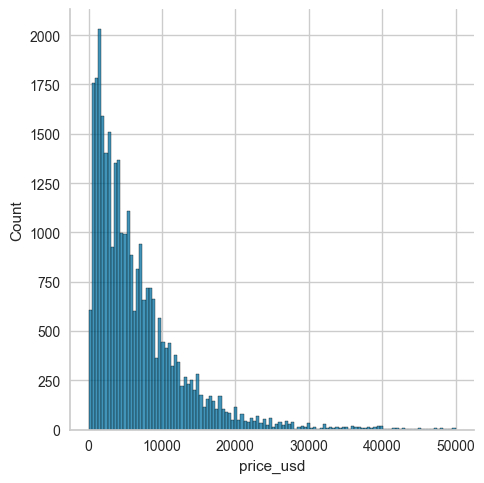

In [4]:
sns.displot(df['price_usd'])

In [5]:
# This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
normaltest(df.price_usd.values)

NormaltestResult(statistic=14747.843370532468, pvalue=0.0)

p-value _extremely_ low. That means distribution of price is not normally distributed.

Linear Regression assumes a normally distributed residuals which can be **aided** by transforming y variable. Let's try some common transformations to try and get y to be normally distributed: 

* Log
* Square root
* Box cox

Log:
NormaltestResult(statistic=1476.7140297245905, pvalue=0.0)


Square Root:
NormaltestResult(statistic=3057.3840527927478, pvalue=0.0)


Boxcox: 
NormaltestResult(statistic=170.356343293092, pvalue=1.0176304069833364e-37)


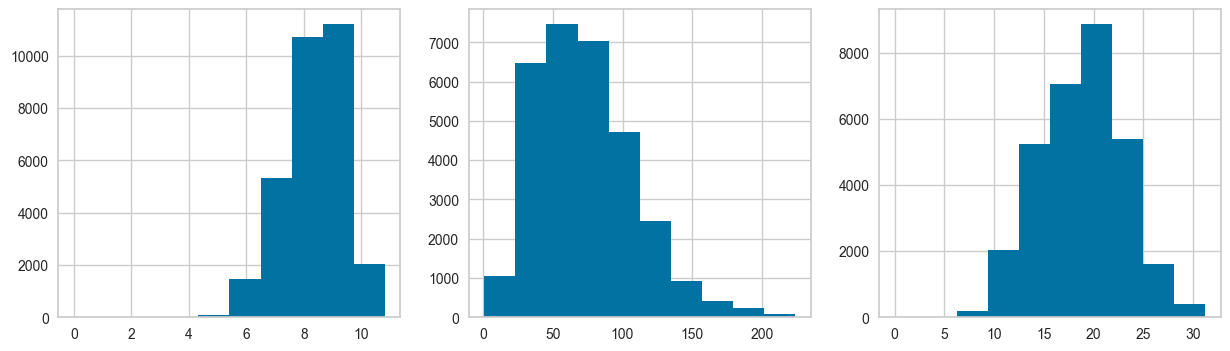

In [6]:
plt.figure(figsize=(15,4))

# log
log_price = np.log(df['price_usd'])
plt.subplot(1,3,1)
plt.hist(log_price)
print('Log:')
print(normaltest(log_price.values))
print('\n')

# Sqrt
sqrt_price = np.sqrt(df.price_usd)
plt.subplot(1,3,2)
plt.hist(sqrt_price)
print('Square Root:')
print(normaltest(sqrt_price.values))
print('\n')

# Boxcox
from scipy.stats import boxcox
bc_result = boxcox(df.price_usd)
boxcox_price = bc_result[0]
lam = bc_result[1]
plt.subplot(1,3,3)
plt.hist(boxcox_price)
print('Boxcox: ')
print(normaltest(pd.Series(boxcox_price).values))

# 2. EDA

As with any Machine Learning project, we firstly need to get an idea of the data by identifying potential patterns and correlations among the variables. The Exploratory Data Analysis (EDA) step usually proves to be crucial before building any model so we, too, will start with that (all following images are created by Author).

It contains information about the engine, body and transmission types, the year produced, the ownership state, the kilometers driven and the manufacturer/model names, as well as their prices. After removing some unknown variables with the name “feature_…”, let’s have a look at the first rows:

In [7]:
# remove unecessary/unknown features
df = df.drop(['feature_0','feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30824 entries, 0 to 30823
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  30824 non-null  object 
 1   model_name         30824 non-null  object 
 2   transmission       30824 non-null  object 
 3   color              30824 non-null  object 
 4   odometer_value     30824 non-null  int64  
 5   year_produced      30824 non-null  int64  
 6   engine_fuel        30824 non-null  object 
 7   engine_has_gas     30824 non-null  bool   
 8   engine_type        30824 non-null  object 
 9   engine_capacity    30816 non-null  float64
 10  body_type          30824 non-null  object 
 11  has_warranty       30824 non-null  bool   
 12  state              30824 non-null  object 
 13  drivetrain         30824 non-null  object 
 14  duration_listed    30824 non-null  int64  
 15  price_usd          30824 non-null  float64
dtypes: bool(2), float64(2)

Some initial observations:

The dataset consists of 30,824 rows and 16 variables (also known as “features”)

The “price_usd” is the target variable (the one we want to predict) and the rest 15 are the predictors (that will help us predict the target)

The target variable is numerical so we have a regression case, whereas the predictors have various types (categorical, boolean and numerical)

Looking at the non-null values, all predictors have the same count as the total rows apart from the “engine_capacity” (30,816). With only 8 null values in this variable, and for simplicity reasons, it is pretty safe to just remove the entire rows.

In [9]:
# look for Nulls in any feature
pd.isna(df).sum()

#  there are few Nulls only in engine_capacity, we can remove those rows entirely

manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      8
body_type            0
has_warranty         0
state                0
drivetrain           0
duration_listed      0
price_usd            0
dtype: int64

In [10]:
# remove rows where engine_capacity is Null
df = df[pd.isna(df['engine_capacity'])==False]
df.reset_index(drop=True, inplace=True)

In [11]:
df.head()

manufacturer_name model_name transmission   color  odometer_value  \
0              Ford     Fusion   mechanical    blue          245000   
1             Dodge    Caravan    automatic  silver          265542   
2              Ford     Galaxy   mechanical    blue          168000   
3             Mazda          6   mechanical   other          225522   
4              Audi         80   mechanical   black          370000   

   year_produced engine_fuel  engine_has_gas engine_type  engine_capacity  \
0           2006    gasoline           False    gasoline             1.60   
1           2002    gasoline           False    gasoline             3.30   
2           2009      diesel           False      diesel             1.80   
3           2008    gasoline           False    gasoline             1.80   
4           1991    gasoline           False    gasoline             1.80   

   body_type  has_warranty  state drivetrain  duration_listed  price_usd  
0  hatchback         False  owned      front                7    4250.00  
1    minivan         False  owned      front              133    4000.00  
2    minivan         False  owned      front                0   10900.00  
3  universal         False  owned      front               20    6999.00  
4      sedan         False  owned      front              160    1600.00

In [12]:
df.describe(include='all')

manufacturer_name model_name transmission  color  odometer_value  \
count              30816      30816        30816  30816        30816.00   
unique                55       1068            2     12             NaN   
top           Volkswagen     Passat   mechanical  black             NaN   
freq                3406       1153        20493   6160             NaN   
mean                 NaN        NaN          NaN    NaN       248848.78   
std                  NaN        NaN          NaN    NaN       135747.23   
min                  NaN        NaN          NaN    NaN            0.00   
25%                  NaN        NaN          NaN    NaN       158500.00   
50%                  NaN        NaN          NaN    NaN       250000.00   
75%                  NaN        NaN          NaN    NaN       325000.00   
max                  NaN        NaN          NaN    NaN      1000000.00   

        year_produced engine_fuel engine_has_gas engine_type  engine_capacity  \
count        30816.00       30816          30816       30816         30816.00   
unique            NaN           5              2           2              NaN   
top               NaN    gasoline          False    gasoline              NaN   
freq              NaN       19259          29746       20511              NaN   
mean          2002.94         NaN            NaN         NaN             2.05   
std              8.05         NaN            NaN         NaN             0.67   
min           1950.00         NaN            NaN         NaN             0.20   
25%           1998.00         NaN            NaN         NaN             1.60   
50%           2003.00         NaN            NaN         NaN             2.00   
75%           2009.00         NaN            NaN         NaN             2.30   
max           2019.00         NaN            NaN         NaN             7.50   

       body_type has_warranty  state drivetrain  duration_listed  price_usd  
count      30816        30816  30816      30816         30816.00   30816.00  
unique        12            2      3          3              NaN        NaN  
top        sedan        False  owned      front              NaN        NaN  
freq       10433        30449  30146      22187              NaN        NaN  
mean         NaN          NaN    NaN        NaN            80.35    6627.40  
std          NaN          NaN    NaN        NaN           112.67    6408.44  
min          NaN          NaN    NaN        NaN             0.00       1.00  
25%          NaN          NaN    NaN        NaN            23.00    2134.12  
50%          NaN          NaN    NaN        NaN            59.00    4800.00  
75%          NaN          NaN    NaN        NaN            91.00    8950.00  
max          NaN          NaN    NaN        NaN          2232.00   50000.00

Let’s start with some basic plots to get an understanding of the data, that will provide useful guidelines for the modeling part:

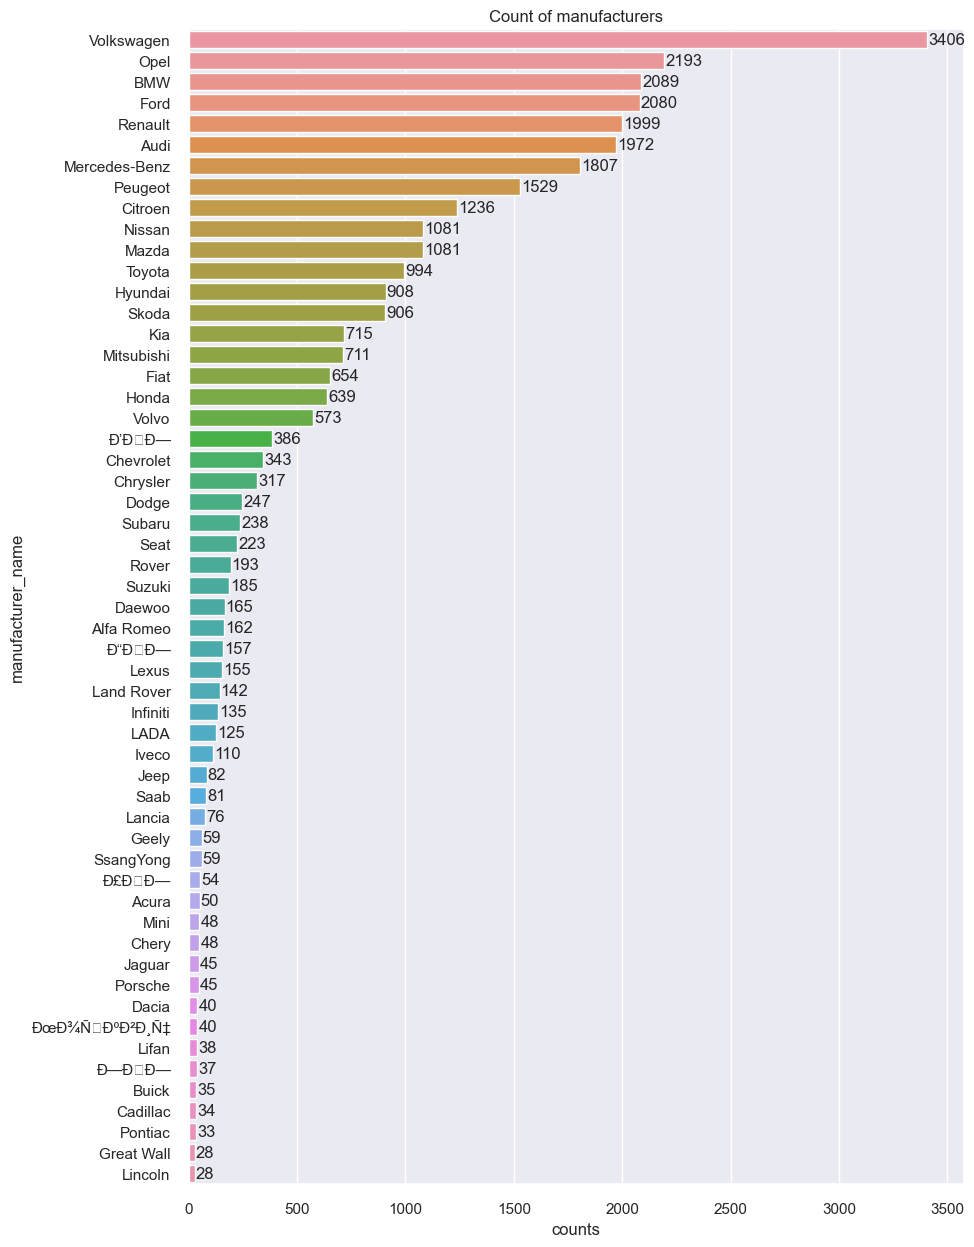

In [13]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='manufacturer_name').size().reset_index(name="counts").sort_values('counts', ascending=False), 
              y='manufacturer_name', x='counts')
ax.set(title="Count of manufacturers") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# Volkswagen is by far the top manufacturer among total 55 companies, in terms of numbers of cars in this dataset.

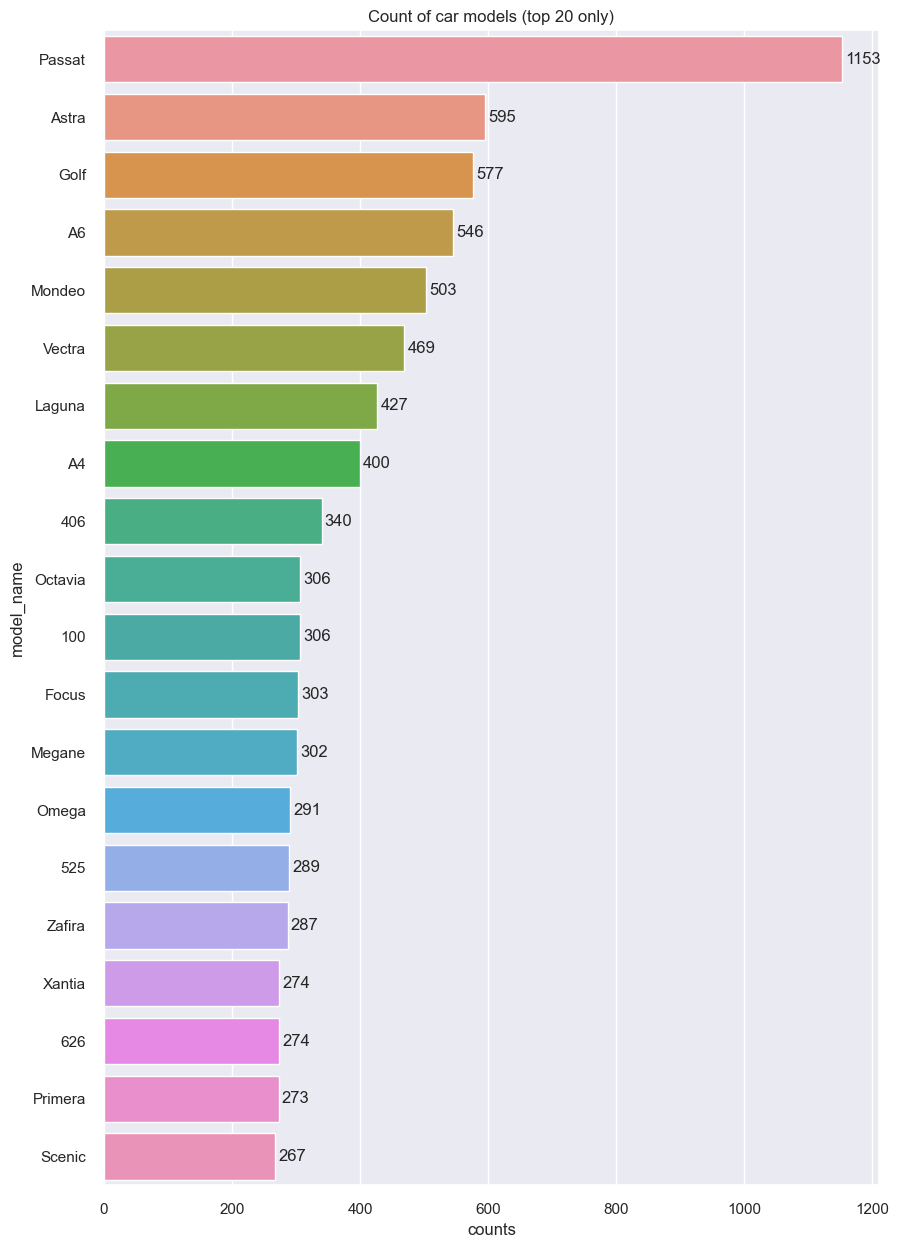

In [14]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='model_name').size().reset_index(name="counts").sort_values('counts', ascending=False).head(20), 
              y='model_name', x='counts')
ax.set(title="Count of car models (top 20 only)") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# Volkswagen is mainly represented by Passat and Golf, whereas Opel from Astra and Vectra.

Volkswagen is by far the top manufacturer among 55 companies in total in terms of number of cars in this dataset, followed by Opel, BMW and Ford.

Moreover, Volkswagen is mainly represented by Passat and Golf, whereas Opel from Astra and Vectra.

Now let’s compare the median prices of the Top 10 manufacturers (we chose the median metric as it is more robust to outliers than the mean):

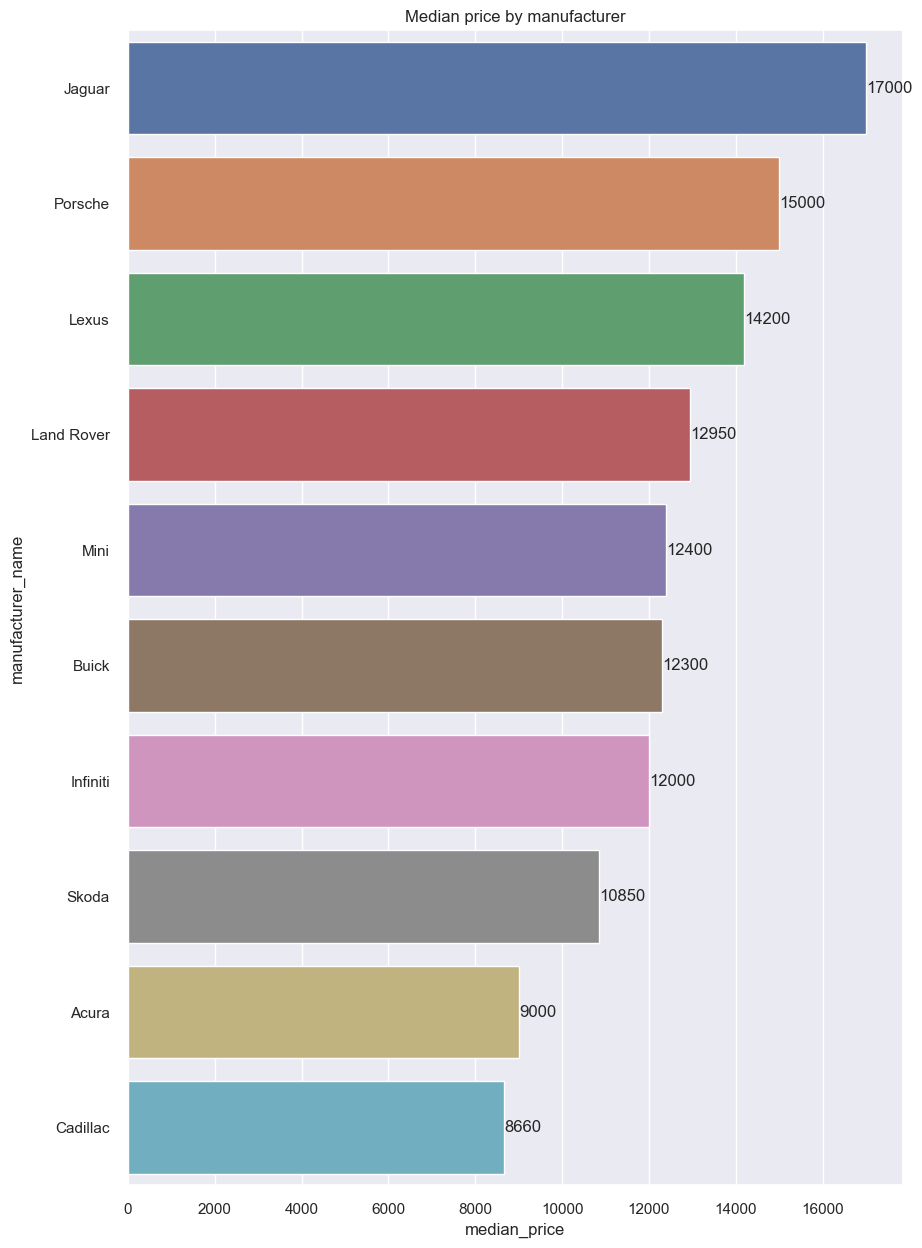

In [15]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='manufacturer_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(10), 
              y='manufacturer_name', x='median_price')
ax.set(title="Median price by manufacturer") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# This plot is more informative, because it creates a distinction between expensive and more affordable manufacturers based on the median price (more robust metric to outliers than mean).

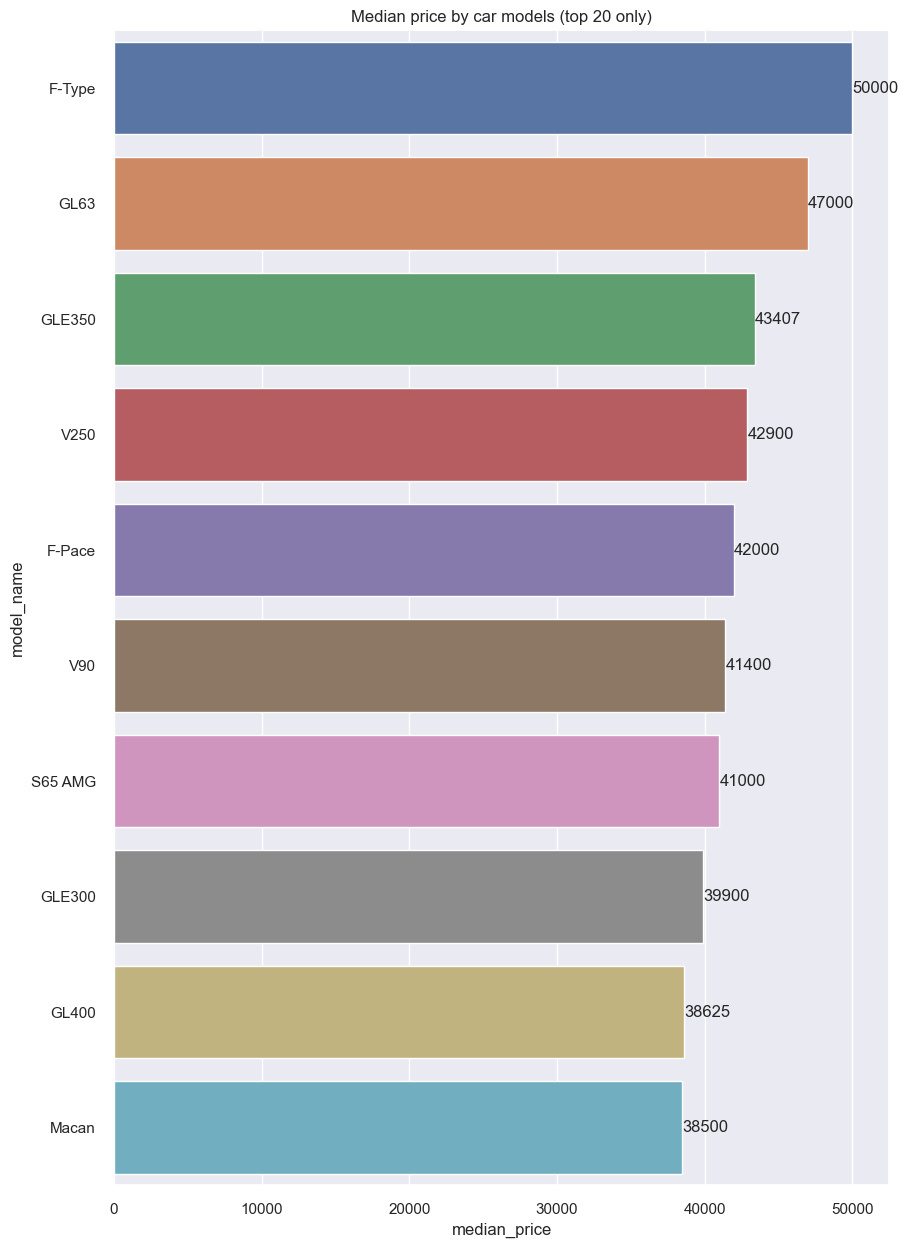

In [16]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='model_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(10), 
              y='model_name', x='median_price')
ax.set(title="Median price by car models (top 20 only)") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center
    

# The 20 most expensive models.

This plot is more informative because it creates a distinction between expensive and more affordable manufacturers based on their median prices. Jaguar, Porsche, Lexus and Land Rover tend to be the most expensive ones although they don’t have lots of representatives in the dataset.

Additional interesting observations can be derived from the price variance of the top 10 manufacturers and models, both by count (i.e. most popular, on the left), and by median price (i.e. most expensive, on the right):

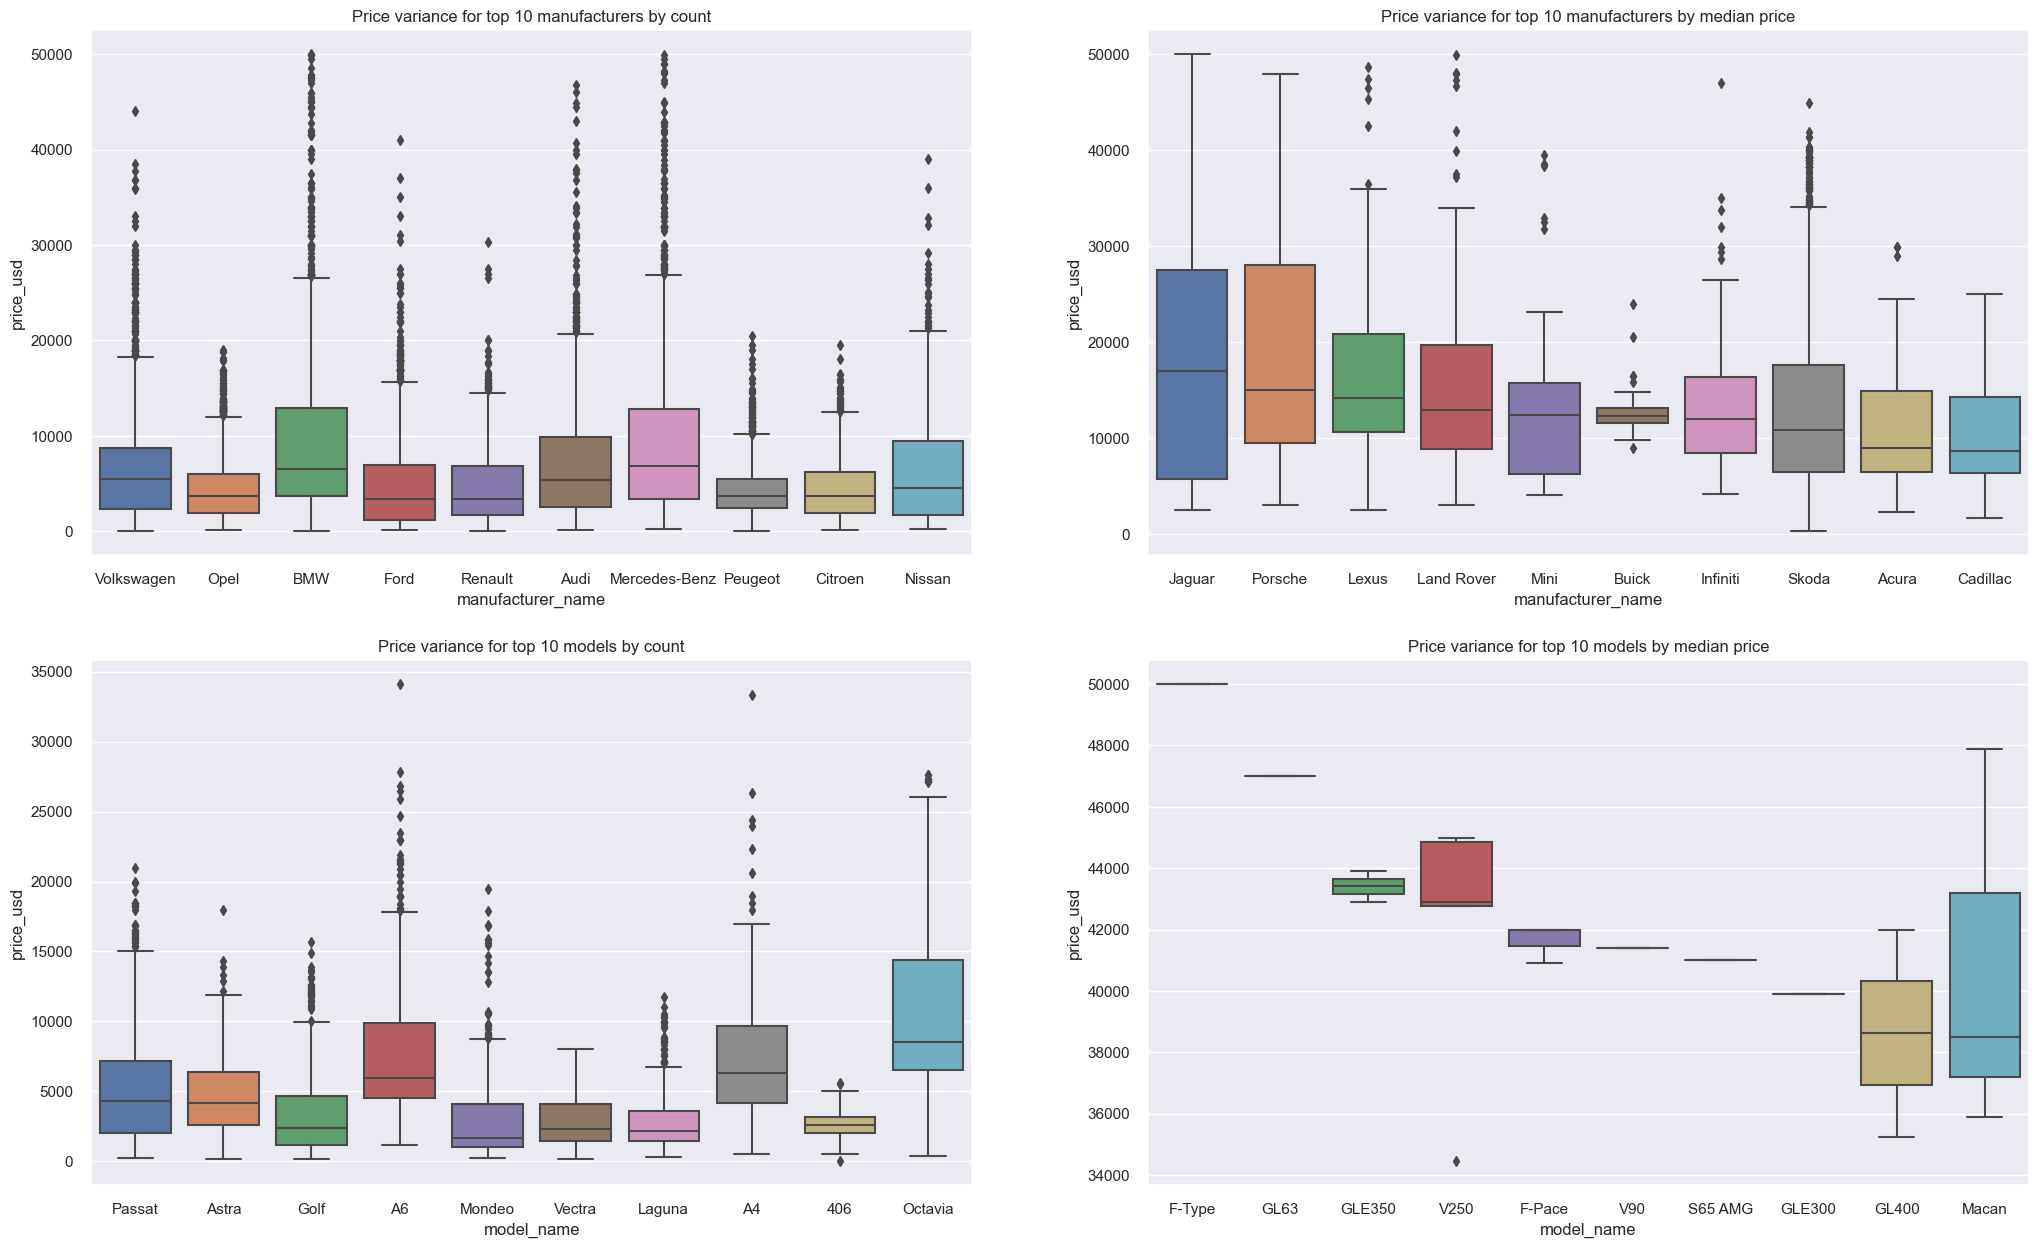

In [17]:
# top 10 brands by count and by median price
top_10_brands_in_count = list(df.groupby(by='manufacturer_name').size().reset_index(name="counts").sort_values('counts', ascending=False).head(10)['manufacturer_name'])
df_top_10_brands_in_count = df[df['manufacturer_name'].isin(top_10_brands_in_count)]

top_10_brands_in_median_price = list(df.groupby(by='manufacturer_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(10)['manufacturer_name'])
df_top_10_brands_in_median_price = df[df['manufacturer_name'].isin(top_10_brands_in_median_price)]


# top 10 models by count and by median price
top_10_models_in_count = list(df.groupby(by='model_name').size().reset_index(name="counts").sort_values('counts', ascending=False).head(10)['model_name'])
df_top_10_models_in_count = df[df['model_name'].isin(top_10_models_in_count)]

top_10_models_in_median_price = list(df.groupby(by='model_name')['price_usd'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(10)['model_name'])
df_top_10_models_in_median_price = df[df['model_name'].isin(top_10_models_in_median_price)]


# plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25,15))

sns.boxplot(data=df_top_10_brands_in_count, x='manufacturer_name', y='price_usd', ax=axs[0][0], order=top_10_brands_in_count)
axs[0][0].set(title='Price variance for top 10 manufacturers by count')
sns.boxplot(data=df_top_10_brands_in_median_price, x='manufacturer_name', y='price_usd', ax=axs[0][1], order=top_10_brands_in_median_price)
axs[0][1].set(title='Price variance for top 10 manufacturers by median price')

sns.boxplot(data=df_top_10_models_in_count, x='model_name', y='price_usd', ax=axs[1][0], order=top_10_models_in_count)
axs[1][0].set(title='Price variance for top 10 models by count')
sns.boxplot(data=df_top_10_models_in_median_price, x='model_name', y='price_usd', ax=axs[1][1], order=top_10_models_in_median_price)
axs[1][1].set(title='Price variance for top 10 models by median price')

print('')

#### Insights: 
# The most popular manufacturers (most counts in the dataset) have less variance in the price than the most expensive ones but have more outliers
# This may be because brands that are mostly expensive have fewer models in the dataset and their prices can more easily be affected by other variables (even variables outside of this dataset, like the "brand name").
# For example, someone who wants to add an Opel car in the dataset might think that the price should be around 4,000 - 5,000 to be competitive against the other cars (either from Opel or not).
# However, when adding a Jaguar there is not muh competition and the price can vary a lot, depending on transmission, state, warranty, engine etc and can reach high levels (it is a Jaguar after all!)
# Same thing happens with models.

#### So: most popular cars (either in terms of manufacturer or model) tend to be more stable in their price ranges.

As a quick interpretation of the box-plots: the more compact it is, the less variance it has. This means that it is more stable in its range. Additionally, the horizontal line refers to the median value (here, to the median price per manufacturer or model). The small dots represent outliers.

The most popular manufacturers (top left) have less variance in their prices but have more outliers than the most expensive ones (top right). The reason is probably because expensive brands have fewer cars in the dataset and their prices can more easily be affected by other variables such as the “brand value” or “brand name”.

For example, someone who might want to add an Opel car in the dataset for sale might think that the price should be around 4,000 to 5,000 in order to be more competitive against other cars (Opel or not). However, when adding a Jaguar there is not much “competition” and the price can vary a lot depending on age, transmission, warranty, state etc and could reach very high levels (it is a Jaguar after all!).

So, a valuable insight is that most popular cars tend to be more stable in their price ranges.

But what about the rest categorical variables? Let’s create a count-plot and a box-plot for each of them to examine their distribution and any correlation with price:

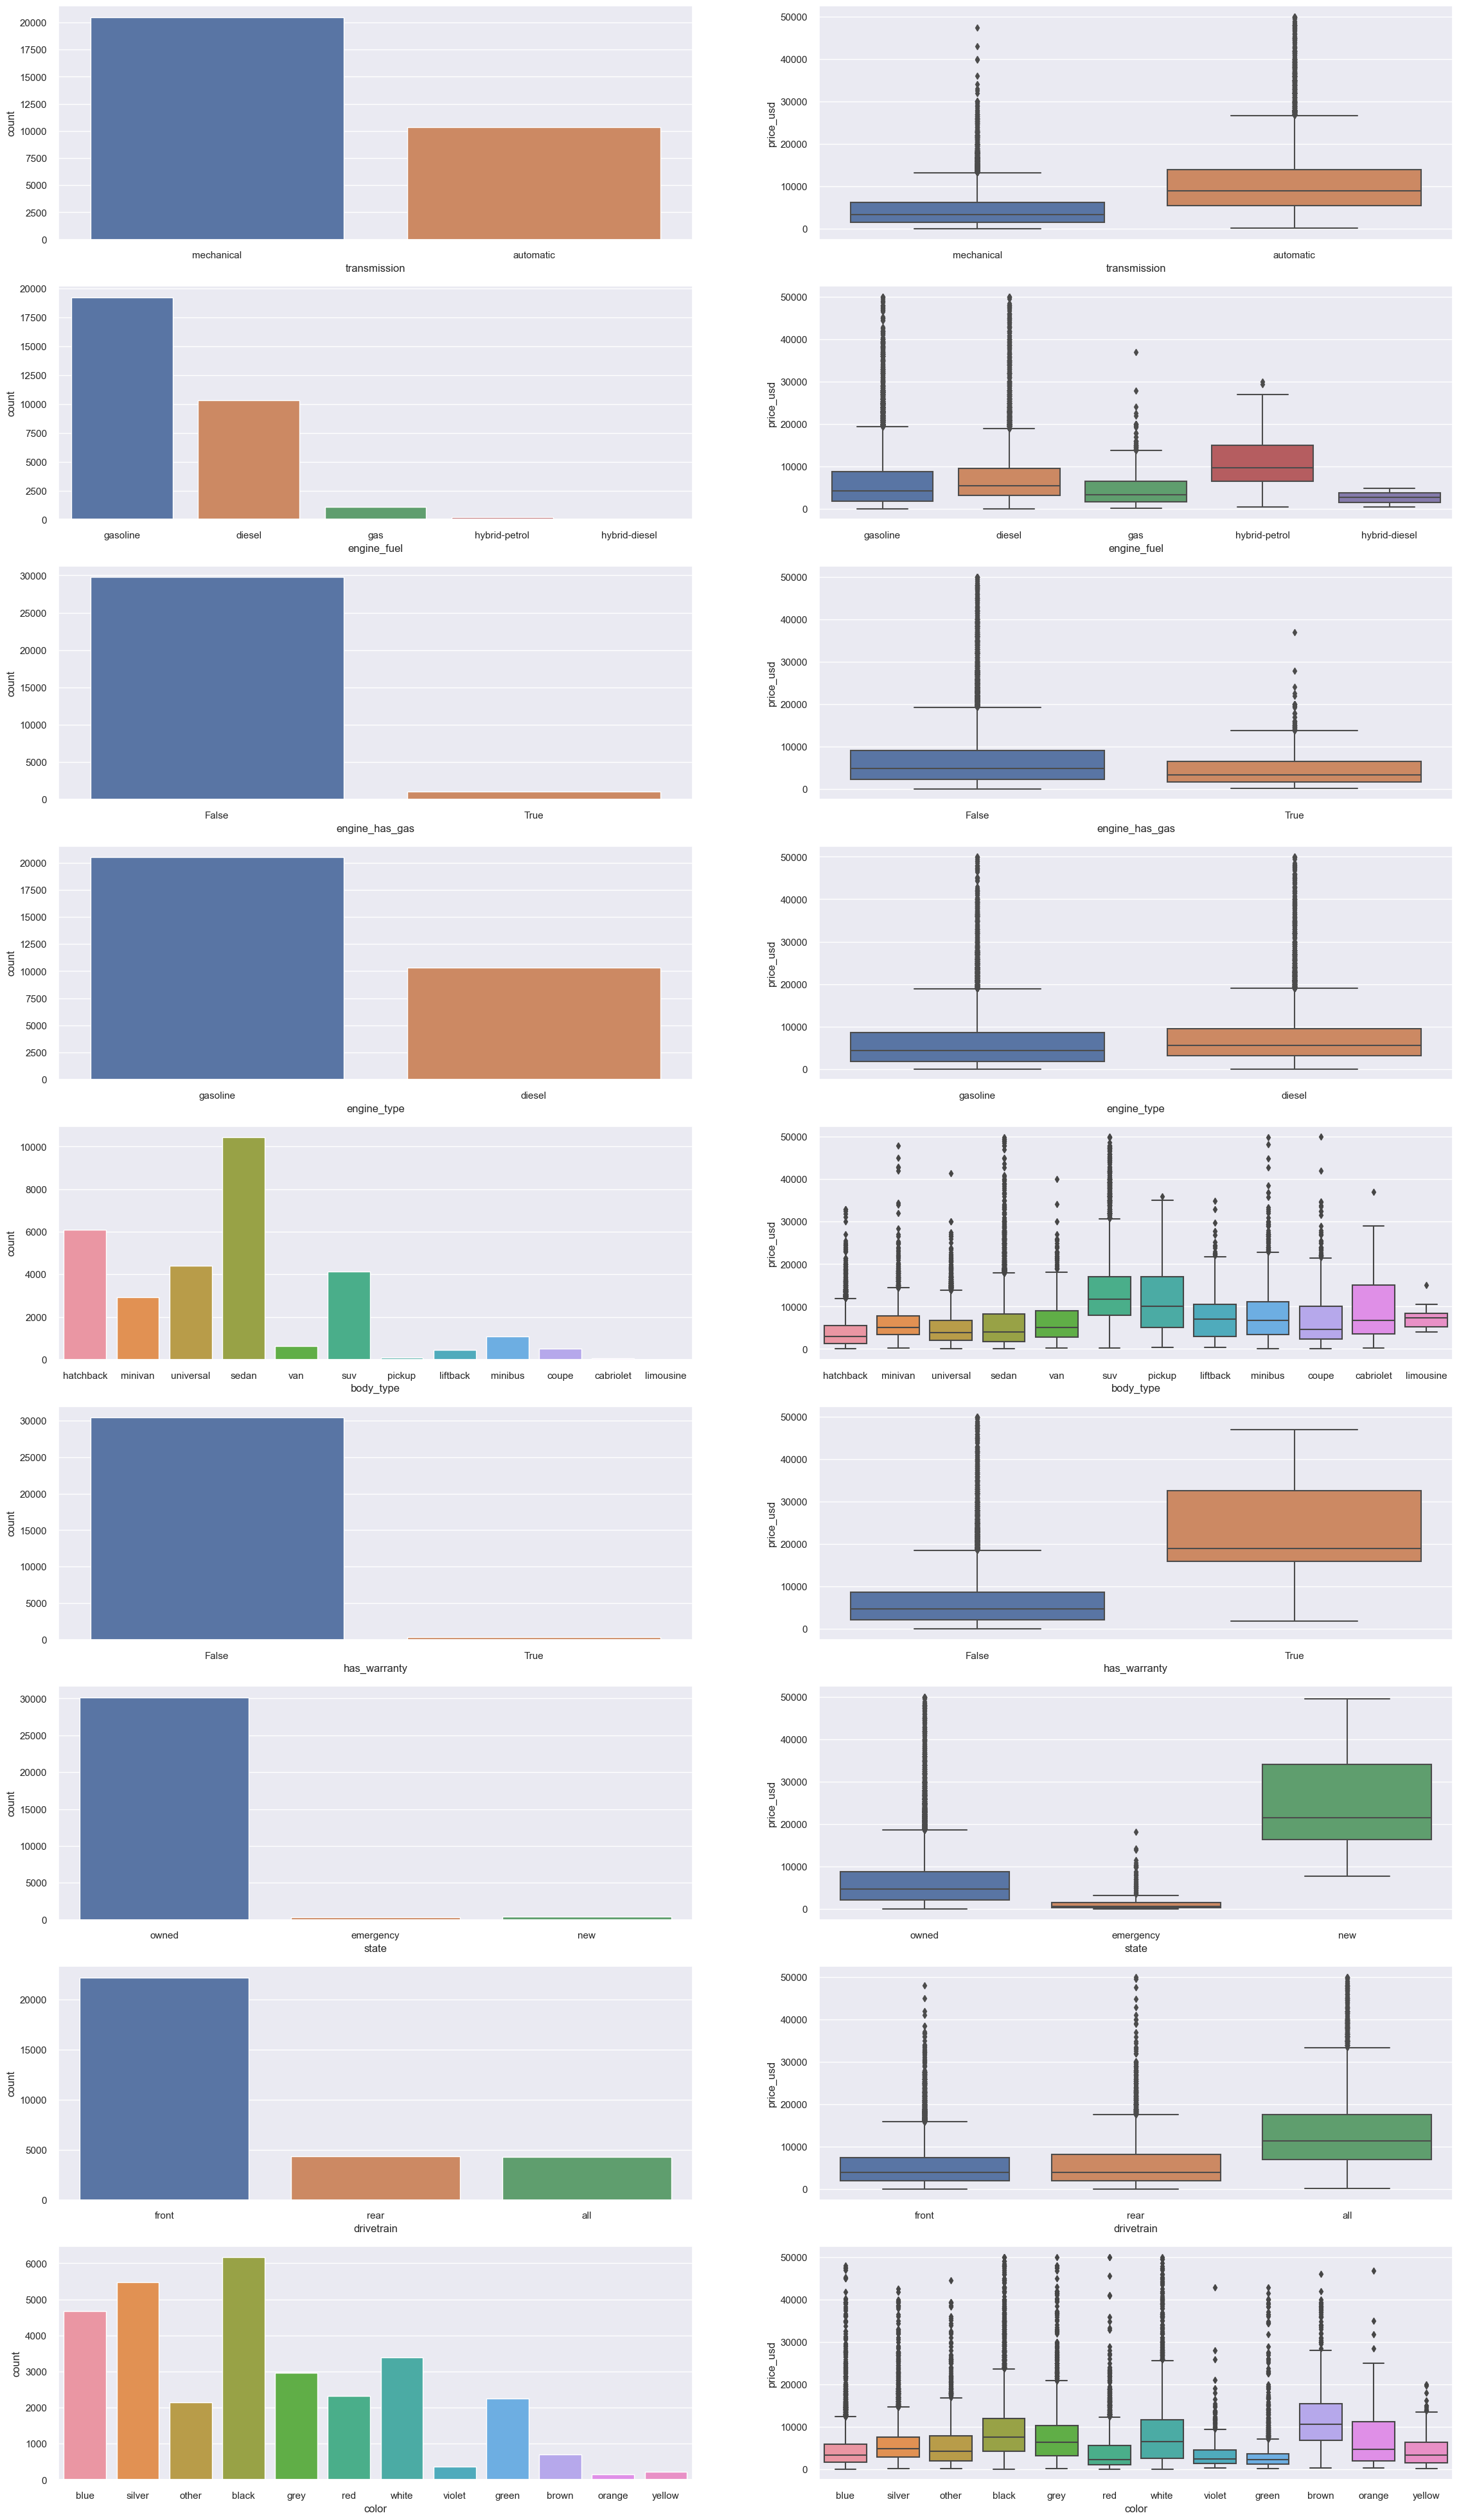

In [18]:
# Plot the categorical variables, both on their own (on the left) and against price (on the right):

fig, axs = plt.subplots(nrows=9, ncols=2, figsize=(28,50))

sns.countplot(data=df, x='transmission', ax=axs[0][0])
sns.boxplot(data=df, x='transmission', y='price_usd', ax=axs[0][1])

sns.countplot(data=df, x='engine_fuel', ax=axs[1][0])
sns.boxplot(data=df, x='engine_fuel', y='price_usd', ax=axs[1][1])

sns.countplot(data=df, x='engine_has_gas', ax=axs[2][0])
sns.boxplot(data=df, x='engine_has_gas', y='price_usd', ax=axs[2][1])

sns.countplot(data=df, x='engine_type', ax=axs[3][0])
sns.boxplot(data=df, x='engine_type', y='price_usd', ax=axs[3][1])

sns.countplot(data=df, x='body_type', ax=axs[4][0])
sns.boxplot(data=df, x='body_type', y='price_usd', ax=axs[4][1])

sns.countplot(data=df, x='has_warranty', ax=axs[5][0])
sns.boxplot(data=df, x='has_warranty', y='price_usd', ax=axs[5][1])

sns.countplot(data=df, x='state', ax=axs[6][0])
sns.boxplot(data=df, x='state', y='price_usd', ax=axs[6][1])

sns.countplot(data=df, x='drivetrain', ax=axs[7][0])
sns.boxplot(data=df, x='drivetrain', y='price_usd', ax=axs[7][1])

sns.countplot(data=df, x='color', ax=axs[8][0])
sns.boxplot(data=df, x='color', y='price_usd', ax=axs[8][1])

print('')

#### Insights:
# -> mechanical cars are double the automatics, however automatics are more expensive (double the price)
# -> sedans and front-drive cars are the most popular, but not most expensive
# -> the engine type and engine fuel is mostly gasoline, but hybrid-petrol the most expensive
# -> vast majority owned and without warranty, but new with guarantee can lead to sigificantly high prices
# -> black and silver the most popular, but brown cars have the highest median price

#### So, it seems that high prices can be related to automatic cars with hybrid-petrol fuel, that 
#### are new and have warranty.

Some useful insights that can be derived:

mechanical cars are double the automatics, however automatics are more expensive (double the price)

sedans and front-drive cars are the most popular, but not most expensive

the engine type and engine fuel is mostly gasoline, but hybrid-petrol the most expensive

vast majority are owned and without warranty, but those that are new with guarantee can lead to significantly high prices

black and silver the most popular, but brown cars have the highest median price

So, it seems that high prices are mostly related to automatic cars with hybrid-petrol fuel, that are new and have warranty.

And as for the numerical variables?

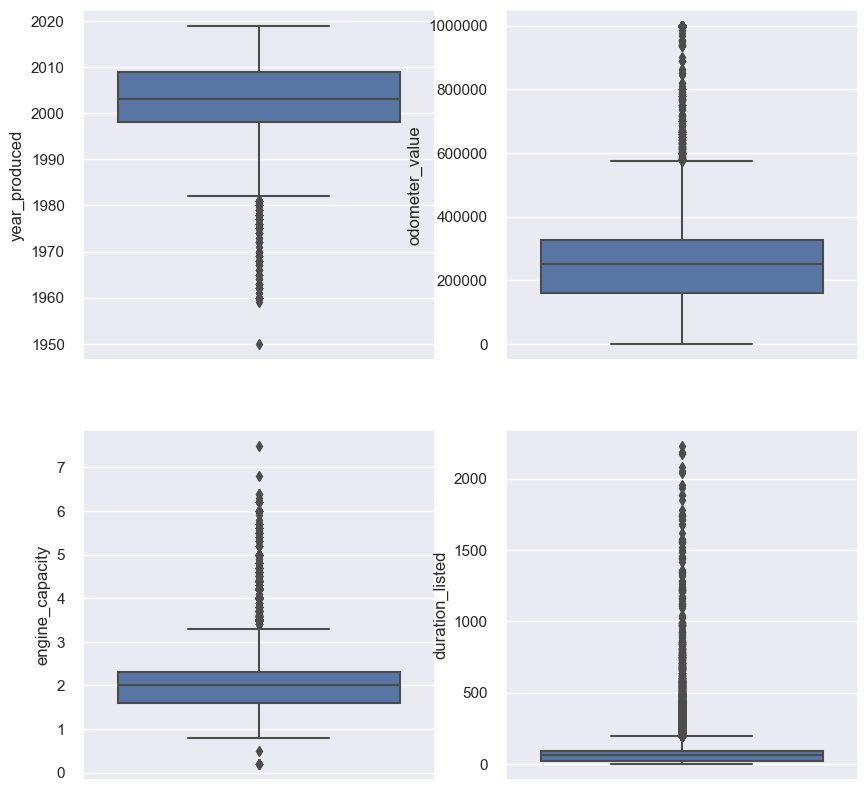

In [19]:
# Plot the numerical variables, on their own:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.boxplot(data=df, y='year_produced', ax=axs[0][0])
sns.boxplot(data=df, y='odometer_value', ax=axs[0][1])
sns.boxplot(data=df, y='engine_capacity', ax=axs[1][0])
sns.boxplot(data=df, y='duration_listed', ax=axs[1][1])

# Update format for each subplot to avoid scientific notation
axs[0][0].ticklabel_format(style='plain', axis='y')
axs[0][1].ticklabel_format(style='plain', axis='y')
axs[1][0].ticklabel_format(style='plain', axis='y')
axs[1][1].ticklabel_format(style='plain', axis='y')

plt.show();

#### Insights:
# -> cars mostly produced around 2002, with avg odometer value of 250K km
# -> mainly with 2 engines, being listed mostly under 100 days

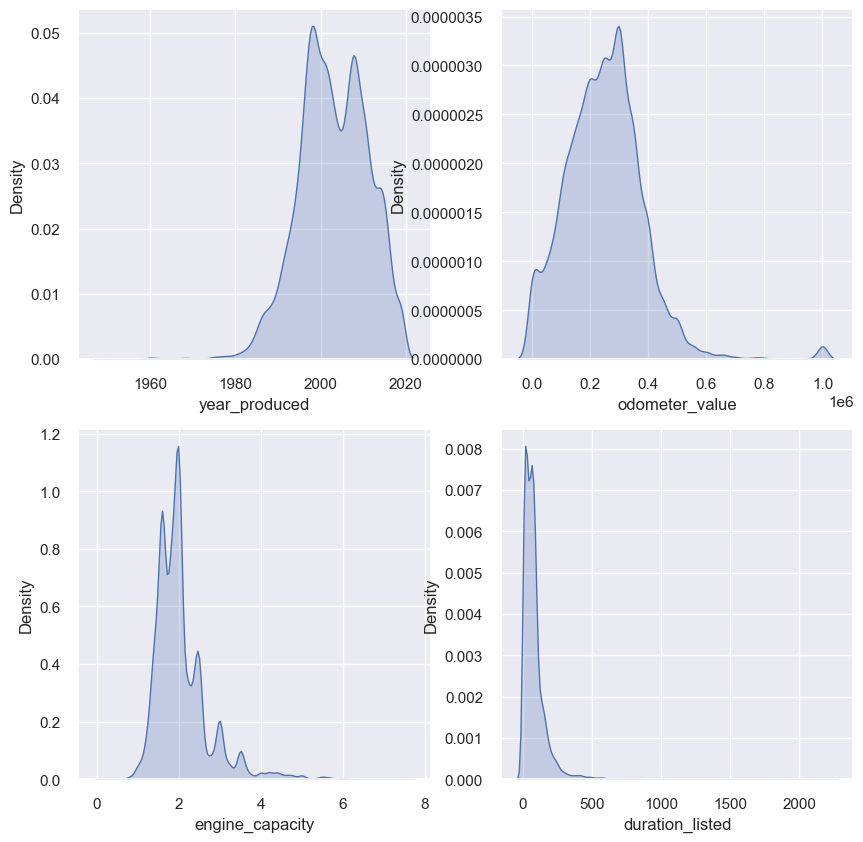

In [20]:
# Plot distribution of numerical variables:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.kdeplot(df.year_produced, ax=axs[0][0], shade=True)
sns.kdeplot(df.odometer_value, ax=axs[0][1], shade=True)
sns.kdeplot(df.engine_capacity, ax=axs[1][0], shade=True)
sns.kdeplot(df.duration_listed, ax=axs[1][1], shade=True)

# Update format for each subplot to avoid scientific notation
axs[0][0].ticklabel_format(style='plain', axis='y')
axs[0][1].ticklabel_format(style='plain', axis='y')
axs[1][0].ticklabel_format(style='plain', axis='y')
axs[1][1].ticklabel_format(style='plain', axis='y')

plt.show();

#### Insights:
# -> no normal distribution in any numerical variable

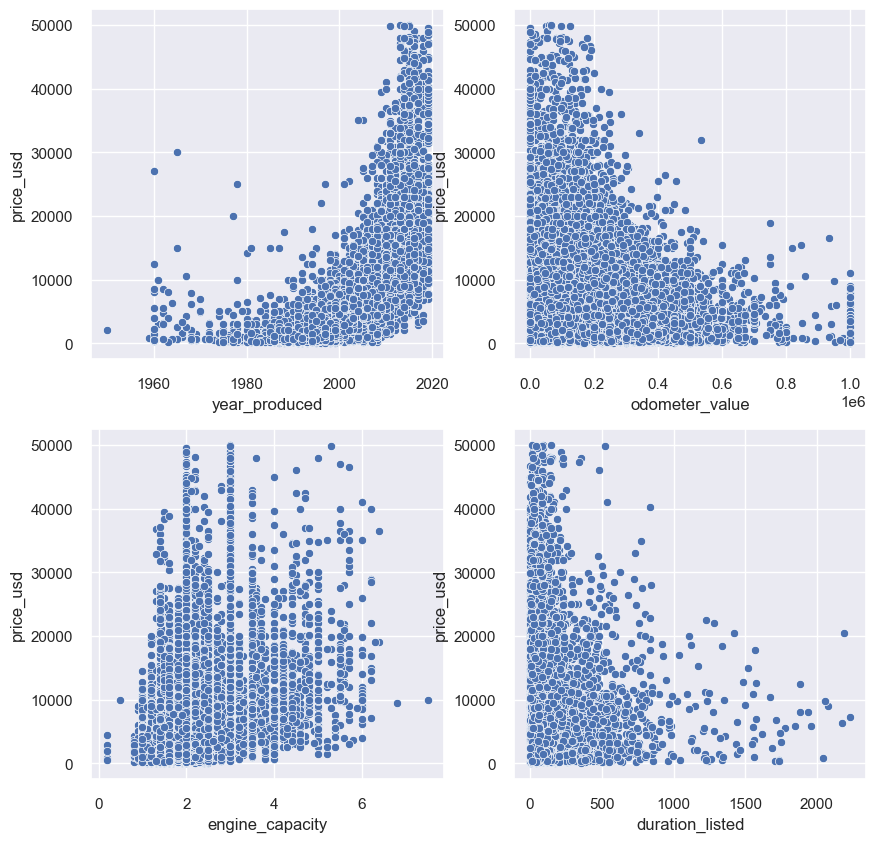

In [21]:
# Plot the relationship between target and numerical variables

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.scatterplot(data=df, x='year_produced',   y='price_usd', ax=axs[0][0])
sns.scatterplot(data=df, x='odometer_value',  y='price_usd', ax=axs[0][1])
sns.scatterplot(data=df, x='engine_capacity', y='price_usd', ax=axs[1][0])
sns.scatterplot(data=df, x='duration_listed', y='price_usd', ax=axs[1][1])

print('')

#### Insights:
# -> no clear linear relationship
# -> year and odometer_value seem to be the most correlated to price

According to the box-plots (on the left image), the cars in the dataset were

mostly produced around 2002

with an average odometer value of 250K kilometers

mainly with 2 engines

being listed mostly under 100 days

Additionally, according to the correlation plots (on the right image), there is no clear linear relationship with price (only “year” and “odometer_value” seem to be the most correlated to price).

# 3. Statistical testing

The target variable (the one to be predicted) is the price, which is a numerical one. As such, according to the nature of the predictors, we can group them into two categories:

In [22]:
# these are dataframes
df_numericals = df.select_dtypes(['int64','float64'])
df_categoricals = df.select_dtypes(['object','bool'])

# these are lists
numericals = [i for i in df_numericals.columns]
categoricals = [i for i in df_categoricals.columns]

print('numericals: ', numericals)
print('categoricals: ', categoricals)

numericals:  ['odometer_value', 'year_produced', 'engine_capacity', 'duration_listed', 'price_usd']
categoricals:  ['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel', 'engine_has_gas', 'engine_type', 'body_type', 'has_warranty', 'state', 'drivetrain']


And now we can apply the following two tests to examine their correlation with the price:

## 3a) numerical target - numerical features: pearson's correlation coefficient

This is a widely used metric when both the target variable and the predictors are numerical features. The closer this coefficient is to 1 or -1, the greater correlation exists (either positive or negative, respectively). In our case, we get the following correlation table:

<AxesSubplot: >

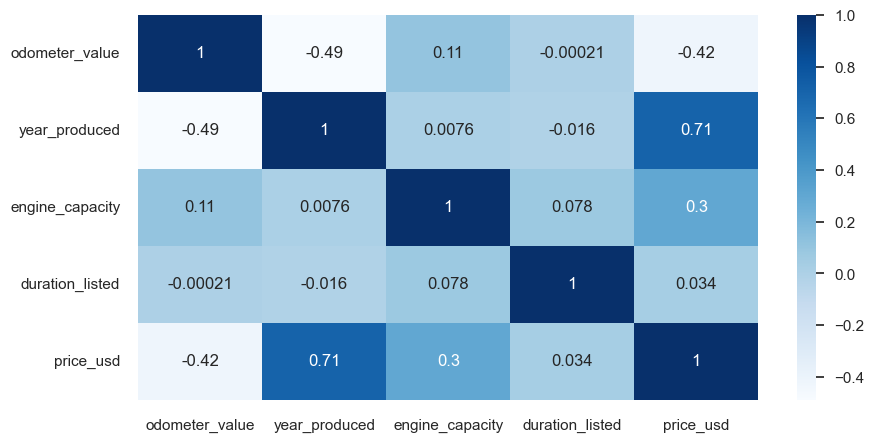

In [23]:
plt.figure(figsize=(10,5))
sns.heatmap(df_numericals.corr(), annot=True, cmap='Blues')

In [24]:
# Keep only "year_produced" and "odometer_value" (remove the other numerical features)
# (those two seem to be mostly related to price_usd, both from heatmap and plots)
df_numericals = df_numericals[['year_produced', 'odometer_value', 'price_usd']]

This table displays the correlation coefficients for every pair of features (the darker blue, the closer to 1). According to these results, we can keep only “year_produced” and odometer_value” as the numerical predictors because those two seem to be mostly correlated to price (look at the last row of the table). This is also in accordance to the insights from the previous correlation plots.

## 3b) numerical target - categorical features: ANOVA test

The ANOVA (ANalysis Of VAriance) test aims to analyze the difference between the means of two or more groups. In simple words, it takes into account the different groups of a categorical feature (for example, the different types of engine) and checks whether the price can be determined from these groups by comparing their mean prices. The null hypothesis (H0) of ANOVA is that there is no statistical difference among the group means and whatever difference happened “by chance”. On the other hand, the alternative hypothesis (Ha) is that at least one group differs significantly from the overall mean of the target variable.

This test returns a p-value (again this p-value??) for every predictor and, whenever this is statistically significant (less than 0.05), then it is likely that the predictor does indeed have a significant effect on the average price of the car.

The coding and results of the ANOVA test:

In [25]:
df['log_price_usd'] = boxcox(df.price_usd)[0]
df

manufacturer_name model_name transmission   color  odometer_value  \
0                  Ford     Fusion   mechanical    blue          245000   
1                 Dodge    Caravan    automatic  silver          265542   
2                  Ford     Galaxy   mechanical    blue          168000   
3                 Mazda          6   mechanical   other          225522   
4                  Audi         80   mechanical   black          370000   
...                 ...        ...          ...     ...             ...   
30811             Mazda   Millenia    automatic   green          360493   
30812              Audi         A3    automatic    grey          117000   
30813             Mazda        626   mechanical   black          333000   
30814              Audi         A6    automatic  violet          530000   
30815             Honda    Odyssey    automatic   white           15000   

       year_produced engine_fuel  engine_has_gas engine_type  engine_capacity  \
0               2006    gasoline           False    gasoline             1.60   
1               2002    gasoline           False    gasoline             3.30   
2               2009      diesel           False      diesel             1.80   
3               2008    gasoline           False    gasoline             1.80   
4               1991    gasoline           False    gasoline             1.80   
...              ...         ...             ...         ...              ...   
30811           1999    gasoline           False    gasoline             2.50   
30812           2009    gasoline           False    gasoline             1.40   
30813           1997    gasoline           False    gasoline             2.00   
30814           1995    gasoline           False    gasoline             2.60   
30815           2018    gasoline           False    gasoline             3.50   

       body_type  has_warranty  state drivetrain  duration_listed  price_usd  \
0      hatchback         False  owned      front                7    4250.00   
1        minivan         False  owned      front              133    4000.00   
2        minivan         False  owned      front                0   10900.00   
3      universal         False  owned      front               20    6999.00   
4          sedan         False  owned      front              160    1600.00   
...          ...           ...    ...        ...              ...        ...   
30811      sedan         False  owned      front               66    2000.00   
30812  universal         False  owned      front               58    8800.00   
30813  hatchback         False  owned      front               87    1400.00   
30814  universal         False  owned        all               52    3500.00   
30815    minivan         False  owned      front               75   42000.00   

       log_price_usd  
0              18.51  
1              18.26  
2              22.76  
3              20.68  
4              14.77  
...              ...  
30811          15.57  
30812          21.73  
30813          14.31  
30814          17.72  
30815          30.16  

[30816 rows x 17 columns]

In [26]:
# See how many values every categorical feature has:
for i in df_categoricals:
    print(i, ':', df_categoricals[i].nunique())

manufacturer_name : 55
model_name : 1068
transmission : 2
color : 12
engine_fuel : 5
engine_has_gas : 2
engine_type : 2
body_type : 12
has_warranty : 2
state : 3
drivetrain : 3


In [27]:
# Define ANOVA test (for a categorical feature against a numerical target)
def anova(df, feature):
    model_ols = ols('price_usd ~ {}'.format(feature), data=df).fit()
    anova_table = anova_lm(model_ols, typ=2)
    return anova_table

In [28]:
# Test for statistical importance of categoricals

anova_for_categoricals = []
for i in categoricals:
    anova_for_categoricals.append([i,anova(df, i).loc[i,'PR(>F)']])

anova_for_categoricals = pd.DataFrame(anova_for_categoricals, columns=['feature','anova pvalue'])
anova_for_categoricals.columns = [str(column) for column in anova_for_categoricals.columns]
anova_for_categoricals

# All pvalues < 0.05, so keep them all.

feature  anova pvalue
0   manufacturer_name          0.00
1          model_name          0.00
2        transmission          0.00
3               color          0.00
4         engine_fuel          0.00
5      engine_has_gas          0.00
6         engine_type          0.00
7           body_type          0.00
8        has_warranty          0.00
9               state          0.00
10         drivetrain          0.00

In [29]:
# Define ANOVA test (for a categorical feature against a numerical target)

def anova_log(df, feature):
    model_ols = ols('log_price_usd ~ {}'.format(feature), data=df).fit()
    anova_table = anova_lm(model_ols, typ=2)
    return anova_table

In [30]:
# Test for statistical importance of categoricals

anova_for_categoricals2 = []
for i in categoricals:
    anova_for_categoricals2.append([i,anova_log(df, i).loc[i,'PR(>F)']])

anova_for_categoricals2 = pd.DataFrame(anova_for_categoricals2, columns=['feature','anova pvalue'])
anova_for_categoricals2.columns = [str(column) for column in anova_for_categoricals2.columns]
anova_for_categoricals2

# All pvalues < 0.05, so keep them all.

feature  anova pvalue
0   manufacturer_name          0.00
1          model_name          0.00
2        transmission          0.00
3               color          0.00
4         engine_fuel          0.00
5      engine_has_gas          0.00
6         engine_type          0.00
7           body_type          0.00
8        has_warranty          0.00
9               state          0.00
10         drivetrain          0.00

In our case, all p-values are very small (less than 0.05), which means that all categorical features are important and should not be removed.

## 3c) final remaining features

The target variable (“price_sd”) is numerical, so we are facing a Regression problem.

The first thought for categorical features is usually transforming them to binary (0 or 1) with One-Hot Encoding. This will create as many new features as the total unique values of all features, encoded as 0 or 1 (note that one value per feature should be left out). Seems a good idea, but how many unique values do our features have?

In [31]:
# Convert "object" type to "category" type, for the ML model later.

for feature in categoricals:
    df_categoricals[feature] = pd.Series(df_categoricals[feature], dtype="category")

Ok, not a good idea.. For example, One-Hot Encoding the “manufacturer_name” will create 54 new features with 0s and 1s. Combining all the features will then result to a very sparse table, which is very unlikely to help the model training.

Another solution would be Label Encoding, that transforms categorical values into numerical ones, by giving every category a different integer value. So instead of having “Opel, BMW, Ford, …” we could have 0, 1, 2, … However, this implies a natural ordering of categories which, in our case, is not true. For example, we cannot say that “BMW with label 1” > “Opel with label 0” (unless we agree to take into consideration the “prestige” parameter!).

Given that we want to keep all these features as predictors according to the ANOVA (ANalysis Of VAriance) results from previous article, we should do exactly this: keep them as they are! Thankfully, there is a well-known and popular machine learning algorithm, with great overall performance so far, that can handle categorical features as “categories” without any encoding at all. Its name? LightGBM ☀️

This is a very powerful, gradient-boosting, tree-based algorithm developed by Microsoft that iteratively trains on errors of previous trees, named as “weak learners”, and fits our need to avoid encoding, so we’ll give it a try.

Remember how the categorical features were defined?

In order to be utilized by LightGBM, the categorical features must be encoded as “categories”. So:

In [32]:
# Combine again all remaining features and the target:

df_remaining = df_categoricals.join(df_numericals)
df_remaining

manufacturer_name model_name transmission   color engine_fuel  \
0                  Ford     Fusion   mechanical    blue    gasoline   
1                 Dodge    Caravan    automatic  silver    gasoline   
2                  Ford     Galaxy   mechanical    blue      diesel   
3                 Mazda          6   mechanical   other    gasoline   
4                  Audi         80   mechanical   black    gasoline   
...                 ...        ...          ...     ...         ...   
30811             Mazda   Millenia    automatic   green    gasoline   
30812              Audi         A3    automatic    grey    gasoline   
30813             Mazda        626   mechanical   black    gasoline   
30814              Audi         A6    automatic  violet    gasoline   
30815             Honda    Odyssey    automatic   white    gasoline   

      engine_has_gas engine_type  body_type has_warranty  state drivetrain  \
0              False    gasoline  hatchback        False  owned      front   
1              False    gasoline    minivan        False  owned      front   
2              False      diesel    minivan        False  owned      front   
3              False    gasoline  universal        False  owned      front   
4              False    gasoline      sedan        False  owned      front   
...              ...         ...        ...          ...    ...        ...   
30811          False    gasoline      sedan        False  owned      front   
30812          False    gasoline  universal        False  owned      front   
30813          False    gasoline  hatchback        False  owned      front   
30814          False    gasoline  universal        False  owned        all   
30815          False    gasoline    minivan        False  owned      front   

       year_produced  odometer_value  price_usd  
0               2006          245000    4250.00  
1               2002          265542    4000.00  
2               2009          168000   10900.00  
3               2008          225522    6999.00  
4               1991          370000    1600.00  
...              ...             ...        ...  
30811           1999          360493    2000.00  
30812           2009          117000    8800.00  
30813           1997          333000    1400.00  
30814           1995          530000    3500.00  
30815           2018           15000   42000.00  

[30816 rows x 14 columns]

In [33]:
df_remaining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30816 entries, 0 to 30815
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   manufacturer_name  30816 non-null  category
 1   model_name         30816 non-null  category
 2   transmission       30816 non-null  category
 3   color              30816 non-null  category
 4   engine_fuel        30816 non-null  category
 5   engine_has_gas     30816 non-null  category
 6   engine_type        30816 non-null  category
 7   body_type          30816 non-null  category
 8   has_warranty       30816 non-null  category
 9   state              30816 non-null  category
 10  drivetrain         30816 non-null  category
 11  year_produced      30816 non-null  int64   
 12  odometer_value     30816 non-null  int64   
 13  price_usd          30816 non-null  float64 
dtypes: category(11), float64(1), int64(2)
memory usage: 1.1 MB


# 4. Define Regression Metrics

## Define Regression Metrics
The first step is to define the metrics on which we will evaluate the performance of the models (keep in mind we will do a lot of testing!).

Two very popular Regression metrics are the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE). Let’s define a function that returns them according to the given true (real) and predicted values:

In [34]:
# Define MAE and RMSE for regression

def evaluate_predictions(true, predictions):
    mae = np.mean(abs(true - predictions))
    rmse = np.sqrt(np.mean((true - predictions) ** 2))  # or: np.sqrt(mean_squared_error(ytrue, ypredicted))
    return mae, rmse

# 5. Train Model

## 5a) Modelling

Then, we separate features (predictors, the “X”) from the target variable (the “y”) and create the Train and Test subsets:

In [35]:
# Separate independent features from target:

X = df_remaining.drop(['price_usd'], axis=1)
y = df_remaining['price_usd']


# Define the train and test datasets for both features and target:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Then, we define the LightGBM Regressor, train it with the Train subset and make predictions on the Test subset.

Lastly, we evaluate our model’s performance with the function we previously created:

In [36]:
# Define the LGBM regressor with default hyperparameters and by specifying 
# the categorical features (to be handled differently by the model):

lgbm = lightgbm.LGBMRegressor(categorical_feature=[0,1,2,3,4,5,6,7,8,9,10])


# Fit on train, predict on test and calculate metrics:
lgbm.fit(X_train, y_train)
y_preds = lgbm.predict(X_test)

lgbm_mae, lgbm_rmse = evaluate_predictions(y_test, y_preds)
lgbm_r2 = r2_score(y_test, y_preds)

print('LightGBM MAE: ', round(lgbm_mae,2))
print('LightGBM RMSE: ', round(lgbm_rmse,2))
print('LightGBM R2: ', round(lgbm_r2,4))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,3,4,5,6,7,8,9,10, categorical_column=0,1,2,3,4,5,6,7,8,9,10 will be ignored. Current value: categorical_feature=0,1,2,3,4,5,6,7,8,9,10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 21571, number of used features: 13
[LightGBM] [Info] Start training from score 6605.647529
LightGBM MAE:  1042.34
LightGBM RMSE:  1889.83
LightGBM R2:  0.9163


Ok, we have a MAE of 1,043.16 USD and RMSE of 1,885.97 USD. The R-squared metric of Regressions gives 91.66%, meaning the model can explain almost 92% of the total variance.

Is an error of 1,043.16 USD (MAE) acceptable or not? How can we measure this? Should we be happy or further improve the model?

These questions shall be firstly answered when compared to some baseline values. For example, we can create a naive baseline model that predicts the median of the Test subset and we compare its performance to our model’s results. Obviously, we don’t want our model to be worse than a naive baseline median!

In [37]:
# Naive baseline is the median

median_pred = y_train.median()
median_preds = [median_pred for _ in range(len(y_test))]

baseline_mae, baseline_rmse = evaluate_predictions(median_preds, y_test)
print('Baseline MAE: ', round(baseline_mae,2))
print('Baseline RMSE: ', round(baseline_rmse,2))

Baseline MAE:  4378.6
Baseline RMSE:  6795.14


## Our model predicts a lot better than just the median. It decreases both errors by around 75%!

## 5b) Diagnostics Plots

Before trying to further improve the model, we can create some diagnostic plots with the help of the “yellowbrick” library in Python. It provides very useful plots for different types of cases, either Regression, Classification or Unsupervised learning.

Let’s focus here on two plots around Regression:

i) Residuals Plot

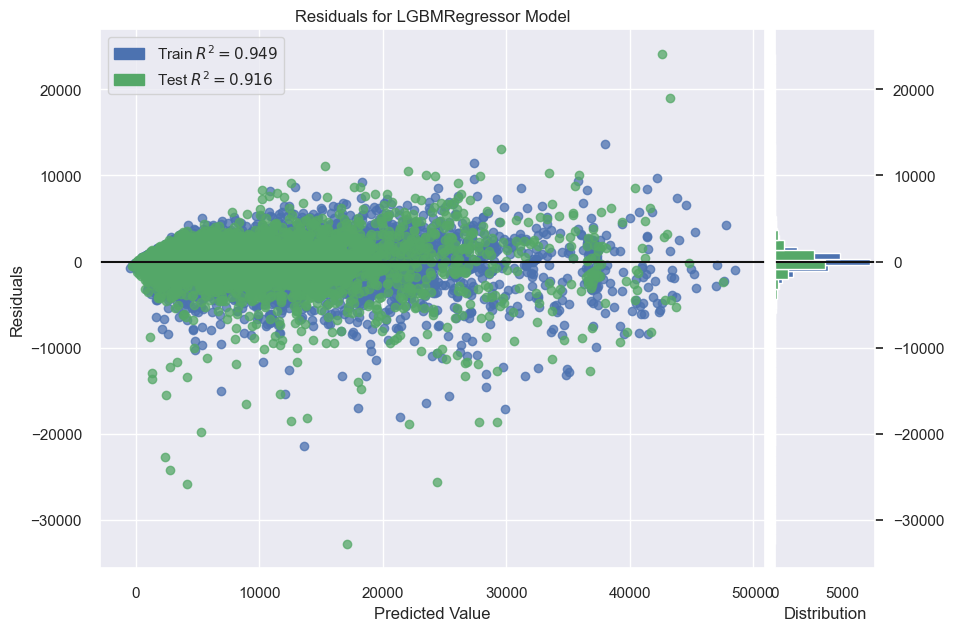

<Axes: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [38]:
fig = plt.figure(figsize=(10,7))
resid_plot = ResidualsPlot(lgbm)

resid_plot.fit(X_train, y_train)  # Fit the training data to the visualizer
resid_plot.score(X_test, y_test)  # Evaluate the model on the test data
resid_plot.show()                 # Finalize and render the figure

# There are larger errors for the smaller-price predictions in the test set.
# Also, train and test R2 are quite similar, so no important trouble of overfitting.

The Residuals (i.e. predicted — actual values) plot displays their relationship/correlation of errors with predictions, as well as the distribution of these errors.

We observe two main points:

The errors are mostly normally distributed (look at the distribution on the right part of the plot), meaning there are no clear patterns of the errors which usually indicates a well-fitted model. However, when we look closely at the down-left side of the plot we can see that there are larger errors for the smaller predictions in the test set area (green dots). For example, we can identify some green cases with predicted value around 5,000 USD and residuals around -25,000 USD. As residuals = predictions — actuals, it is clearly understood that the real prices of those cases vary around 30,000 USD, meaning that the model tends to underforecast (i.e. underestimate prices) a bit.
The train and test R-squared metrics are quite similar (train: 94.9%, test: 91.7%) so there is no important trouble of overfitting, otherwise the train R2 would be a lot higher than the test R2.
ii) Prediction Error Plot

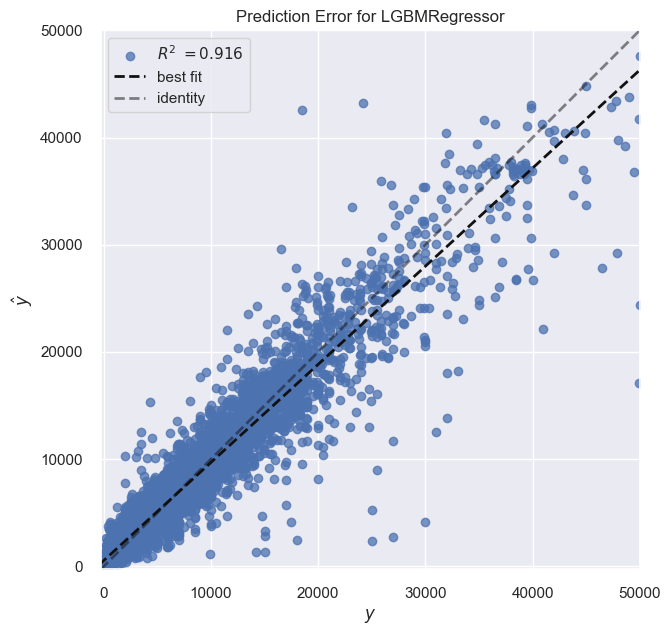

<Axes: title={'center': 'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [39]:
fig = plt.figure(figsize=(10,7))
pred_error = PredictionError(lgbm)

pred_error.fit(X_train, y_train)  # Fit the training data to the visualizer
pred_error.score(X_test, y_test)  # Evaluate the model on the test data
pred_error.show()                 # Finalize and render the figure

# The fit diagonal (actuals VS predictions) is almost on top of the pure diagonal, that means 
# a very  good fit.
# There are more datapoints under the diagonal, that means the model tends to underestimate 
# in general (both expensive and cheaper cars).

This plot displays the actual values of the test set (“y”, in the horizontal axis) versus their predictions (“y-hat”, in the vertical axis) to investigate the model’s variance. Cases that fall on the 45 degree line indicate magnificent predictions, where the predicted value is equal to the actual.

Again, two main points from here:

# The fit diagonal (actuals VS predictions) is almost on top of the pure diagonal, that means a very  good fit.


# There are more datapoints under the diagonal, that means the model tends to underestimate in general (both expensive and cheaper cars).

This is in accordance to the previous Residuals plot insight.

2d. Improve model with GridSearchCV

Now that we have our model we will try to improve it with GridSearch Cross-Validation (GSCV) technique, that finds the optimal combination of given hyperparameters and selects those that maximize the performance.

We provide the trained model, along with a set of hyperparameters, and let the algorithm find the optimal one:

## 5c) Find Optimal Hyperparameters with GridSearchCV

In [40]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[50, 100, 150, 200], 
          'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5], 
          'num_leaves':[10, 50, 100, 200],
          'max_depth':[-1]}


gscv = GridSearchCV(lgbm, params, n_jobs=-1)
gscv.fit(X_train, y_train)

lgbm_cv = gscv.best_estimator_
print(lgbm_cv)

y_preds_lgbm_cv = lgbm_cv.predict(X_test)

lgbm_cv_mae, lgbm_cv_rmse = evaluate_predictions(y_test, y_preds_lgbm_cv)
lgbm_cv_r2 = r2_score(y_test, y_preds_lgbm_cv)

print('LightGBM MAE with CV: ', round(lgbm_cv_mae,2))
print('LightGBM RMSE with CV: ', round(lgbm_cv_rmse,2))
print('LightGBM R2 with CV: ', round(lgbm_cv_r2,4))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,3,4,5,6,7,8,9,10, categorical_column=0,1,2,3,4,5,6,7,8,9,10 will be ignored. Current value: categorical_feature=0,1,2,3,4,5,6,7,8,9,10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 21571, number of used features: 13
[LightGBM] [Info] Start training from score 6605.647529
LGBMRegressor(categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              learning_rate=0.05, n_estimators=200, n_jobs=-1, num_leaves=100)
LightGBM MAE with CV:  1022.83
LightGBM RMSE with CV:  1865.32
LightGBM R2 with CV:

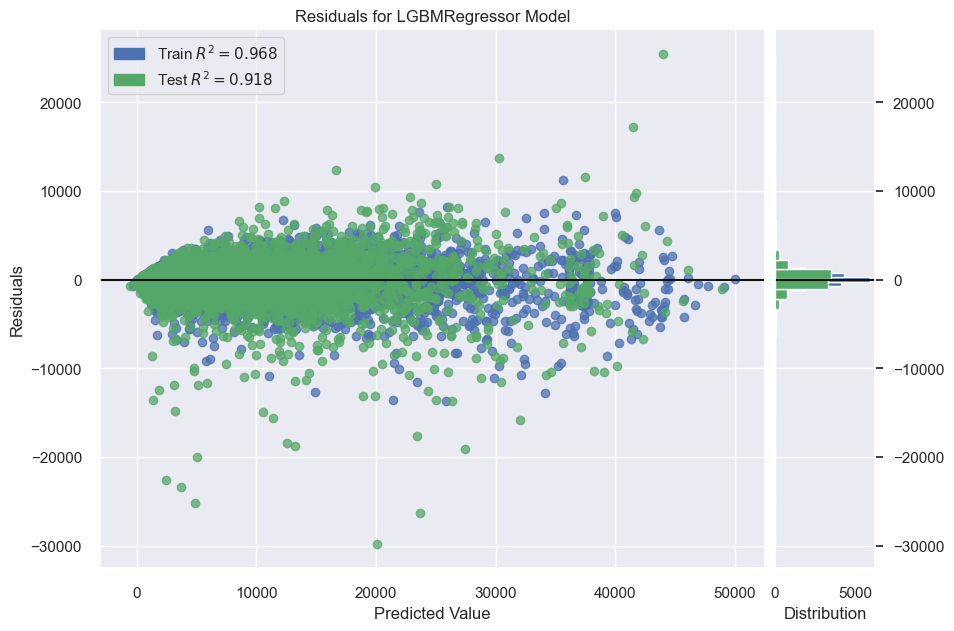

<Axes: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [41]:
fig = plt.figure(figsize=(10,7))
resid_plot = ResidualsPlot(lgbm_cv)

resid_plot.fit(X_train, y_train)  # Fit the training data to the visualizer
resid_plot.score(X_test, y_test)  # Evaluate the model on the test data
resid_plot.show()                 # Finalize and render the figure

## Plot of Problem predictions

In [42]:
car_type = X_test['manufacturer_name'].astype(str) + ' ' + X_test['model_name'].astype(str)
car_type

19139             Volkswagen T5
27516               Opel Vectra
1610     Mercedes-Benz Sprinter
18479               Ford Mondeo
29845               Opel Meriva
                  ...          
21790       Mercedes-Benz ML350
21881               Ð“ÐÐ— 3110
16250               Peugeot 806
810                      BMW X5
22636            Renault Megane
Length: 9245, dtype: object

In [43]:
actual_values = np.array(y_test)  # your actual values here
predicted_values = np.array(y_preds_lgbm_cv)

In [44]:
# Calculate residuals
residuals = actual_values - predicted_values

In [71]:
threshold = 10000

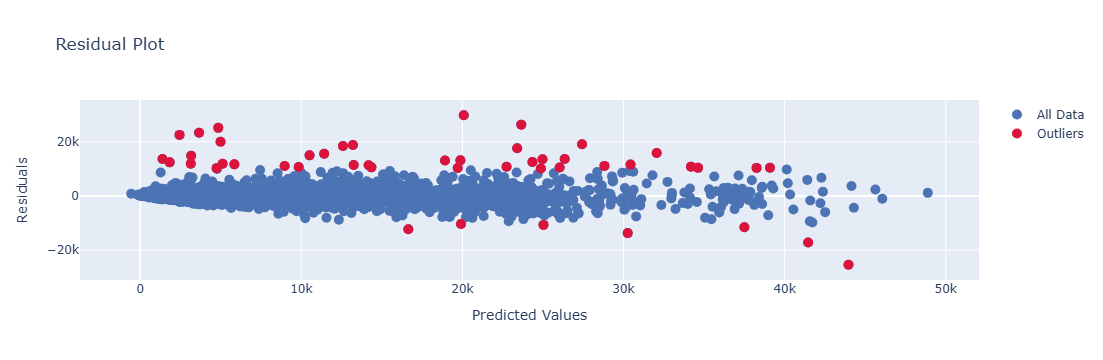

In [72]:
# Create traces
trace_all = go.Scatter(
    x=predicted_values,
    y=residuals,
    mode='markers',
    name='All Data',
    marker=dict(
        color='#4c74b4',  # custom blue color
        size=10), text=car_type,  # Add car type labels
    hoverinfo='text+y+x')

trace_outliers = go.Scatter(
    x=predicted_values[abs(residuals) > threshold],
    y=residuals[abs(residuals) > threshold],
    mode='markers',
    name='Outliers',
    marker=dict(
        color='crimson',  # keeping outliers in crimson for contrast
        size=10), text=car_type[abs(residuals) > threshold],  # Add car type labels for outliers
    hoverinfo='text+y+x')

# Layout
layout = go.Layout(
    title='Residual Plot',
    xaxis=dict(title='Predicted Values'),
    yaxis=dict(title='Residuals'),
    hovermode='closest')

# Figure
fig = go.Figure(data=[trace_all, trace_outliers], layout=layout)

# Display
fig.show();

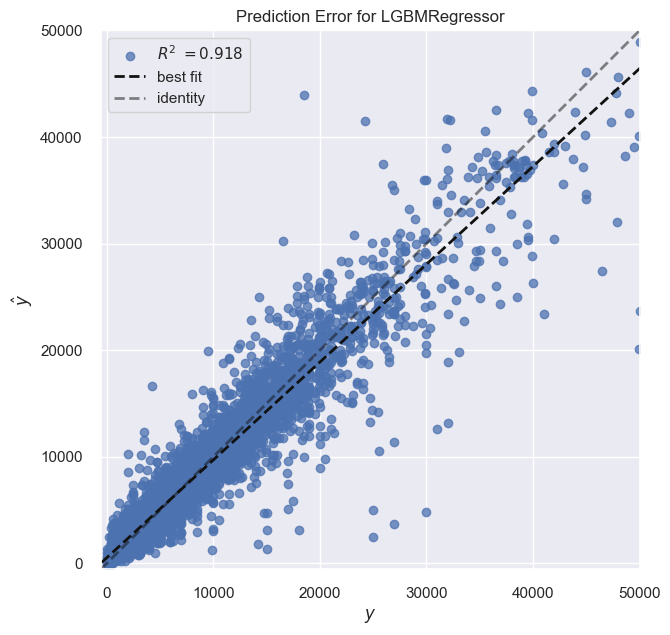

<Axes: title={'center': 'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [73]:
fig = plt.figure(figsize=(10,7))
pred_error = PredictionError(lgbm_cv)

pred_error.fit(X_train, y_train)  # Fit the training data to the visualizer
pred_error.score(X_test, y_test)  # Evaluate the model on the test data
pred_error.show()                 # Finalize and render the figure

# there are larger errors for more expensive cars

## A little better performance but still not improved the underestimation and larger error in smaller-price predictions (in the test set)..

## 5d) Quick Investigation on greatest errors

Can we find any patterns in the cases where we have the greatest errors? Let’s find out:

In [48]:
X_test_with_y = X_test.copy()
X_test_with_y['y_preds'] = y_preds_lgbm_cv
X_test_with_y['y_true'] = y_test
X_test_with_y['error'] = X_test_with_y['y_preds'] - X_test_with_y['y_true']
X_test_with_y['abs_error'] = abs(X_test_with_y['error'])
X_test_with_y.reset_index(drop=True, inplace=True)

In [49]:
greatest_errors_df = X_test_with_y[X_test_with_y['abs_error']>=10000].sort_values(by='abs_error', ascending=False)
greatest_errors_df

manufacturer_name         model_name transmission   color engine_fuel  \
5645         Chevrolet            Express    automatic   black    gasoline   
7574            Jaguar             F-Type    automatic     red    gasoline   
5270     Mercedes-Benz           Sprinter    automatic   white      diesel   
8075            Ð“ÐÐ—                 21   mechanical   black    gasoline   
7792            Ð“ÐÐ—               Ðœ20   mechanical   brown    gasoline   
8271            Ð“ÐÐ—                 24   mechanical   other    gasoline   
679      Mercedes-Benz               S500    automatic    blue    gasoline   
3284             Lexus                 LX    automatic   black    gasoline   
2315     Mercedes-Benz           Sprinter   mechanical   white      diesel   
1218            Toyota            Sequoia    automatic   other    gasoline   
3444     Mercedes-Benz            S65 AMG    automatic    grey    gasoline   
5554               BMW                 X5    automatic   black      diesel   
7292        Land Rover        Range Rover    automatic   black    gasoline   
8860            Nissan             Navara    automatic   black      diesel   
1105     Mercedes-Benz               G270    automatic   black      diesel   
5749               BMW                Ðœ5   mechanical  violet    gasoline   
7443               BMW                118    automatic  orange    gasoline   
7445            Toyota       Land Cruiser    automatic   black      diesel   
2973              Audi                 90   mechanical    blue    gasoline   
688            Porsche              Macan    automatic   black    gasoline   
520      Mercedes-Benz               E350    automatic  silver      diesel   
8102             Lexus                 LX    automatic   black    gasoline   
1897            Toyota       Land Cruiser    automatic   black         gas   
74              Nissan            Skyline   mechanical   white    gasoline   
2065        Volkswagen                 T5   mechanical   white      diesel   
3637            Jaguar                XKR    automatic   green    gasoline   
686         Alfa Romeo                156   mechanical     red    gasoline   
7717            Nissan              200SX   mechanical     red    gasoline   
1763     Mercedes-Benz             CLA250    automatic   black    gasoline   
2692        Land Rover  Range Rover Sport    automatic    grey    gasoline   
2363            Toyota            Alphard    automatic   black    gasoline   
222              Iveco              Daily   mechanical   white      diesel   
5342        Land Rover           Defender   mechanical   green      diesel   
5602        Volkswagen             Touran   mechanical    blue      diesel   
3054               BMW                 X4    automatic   white    gasoline   
8855     Mercedes-Benz             GLC250    automatic   black    gasoline   
5952          Infiniti                 QX    automatic   white    gasoline   
2108            Toyota            4Runner    automatic   black    gasoline   
3253             Honda             Accord    automatic   white    gasoline   
5951             Mazda               CX-9    automatic   black    gasoline   
8813     Mercedes-Benz           Sprinter   mechanical   white      diesel   
7630               BMW                520    automatic   white    gasoline   
4633            Jaguar                 XF    automatic    blue    gasoline   
4064             Lexus                 RX    automatic   white    gasoline   
6484     Mercedes-Benz               E250   mechanical   black      diesel   
3791               BMW                318   mechanical   other    gasoline   
8438               Kia             Mohave    automatic   black      diesel   

     engine_has_gas engine_type  body_type has_warranty      state drivetrain  \
5645          False    gasoline    minibus        False      owned        all   
7574          False    gasoline      coupe        False      owned       rear   
5270          Fal

## All of the cases that the model underestimates do not have gas, do not have warranty and are previously owned. These are features that usually bring the price down, so they must have overtaken the other features (e.g. mostly expensive brands).
## Also, we see older cars but with small odometer values. In these cases, the very old age must have brought the price down taking the other features into account, too (e.g. mechanical)

In [50]:
# Let's log the price (to make it more like normal) and find the optimal model with GridSearchCV:

lgbmlog = lightgbm.LGBMRegressor(categorical_feature=[0,1,2,3,4,5,6,7,8,9,10], n_jobs=-1)
y_train_log = np.log(y_train+0.0001)  # add a constant, although for this dataset we won't have any 0 values

params = {'n_estimators':[50, 100, 150, 200], 
          'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.5], 
          'num_leaves':[10, 50, 100, 200],
          'max_depth':[-1]}

gscv_log = GridSearchCV(lgbmlog, params, n_jobs=-1)
gscv_log.fit(X_train, y_train_log)

lgbm_log = gscv_log.best_estimator_

# these will be logged predictions:
y_preds_logged = lgbm_log.predict(X_test)

# inverse-transofrm the predictions, to bring them to real units (as the original target)
y_preds_unlogged = np.exp(y_preds_logged)-0.0001

# calculate the new metrics:
lgbm_mae_unlogged, lgbm_rmse_unlogged = evaluate_predictions(y_test, y_preds_unlogged)
lgbm_r2_unlogged = r2_score(y_test, y_preds_unlogged)

print('LightGBM_unlogged MAE: ', round(lgbm_mae_unlogged,2))
print('LightGBM_unlogged RMSE: ', round(lgbm_rmse_unlogged,2))
print('LightBM_unlogged R2: ', round(lgbm_r2_unlogged,4))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] categorical_feature is set=0,1,2,3,4,5,6,7,8,9,10, categorical_column=0,1,2,3,4,5,6,7,8,9,10 will be ignored. Current value: categorical_feature=0,1,2,3,4,5,6,7,8,9,10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 21571, number of used features: 13
[LightGBM] [Info] Start training from score 8.350138
LightGBM_unlogged MAE:  1056.0
LightGBM_unlogged RMSE:  1987.93
LightBM_unlogged R2:  0.9073


## Not much of an improvement.
## Now see the predictions with the log model on the previous greatest errors:

In [51]:
X_test_with_y['y_preds_log_model'] = y_preds_unlogged
X_test_with_y['error_log_model'] = X_test_with_y['y_preds_log_model'] - X_test_with_y['y_true']
X_test_with_y['abs_error_log_model'] = abs(X_test_with_y['error_log_model'])
X_test_with_y.reset_index(drop=True, inplace=True)

greatest_errors_df = X_test_with_y[X_test_with_y['abs_error']>=10000].sort_values(by='abs_error', ascending=False)
greatest_errors_df

manufacturer_name         model_name transmission   color engine_fuel  \
5645         Chevrolet            Express    automatic   black    gasoline   
7574            Jaguar             F-Type    automatic     red    gasoline   
5270     Mercedes-Benz           Sprinter    automatic   white      diesel   
8075            Ð“ÐÐ—                 21   mechanical   black    gasoline   
7792            Ð“ÐÐ—               Ðœ20   mechanical   brown    gasoline   
8271            Ð“ÐÐ—                 24   mechanical   other    gasoline   
679      Mercedes-Benz               S500    automatic    blue    gasoline   
3284             Lexus                 LX    automatic   black    gasoline   
2315     Mercedes-Benz           Sprinter   mechanical   white      diesel   
1218            Toyota            Sequoia    automatic   other    gasoline   
3444     Mercedes-Benz            S65 AMG    automatic    grey    gasoline   
5554               BMW                 X5    automatic   black      diesel   
7292        Land Rover        Range Rover    automatic   black    gasoline   
8860            Nissan             Navara    automatic   black      diesel   
1105     Mercedes-Benz               G270    automatic   black      diesel   
5749               BMW                Ðœ5   mechanical  violet    gasoline   
7443               BMW                118    automatic  orange    gasoline   
7445            Toyota       Land Cruiser    automatic   black      diesel   
2973              Audi                 90   mechanical    blue    gasoline   
688            Porsche              Macan    automatic   black    gasoline   
520      Mercedes-Benz               E350    automatic  silver      diesel   
8102             Lexus                 LX    automatic   black    gasoline   
1897            Toyota       Land Cruiser    automatic   black         gas   
74              Nissan            Skyline   mechanical   white    gasoline   
2065        Volkswagen                 T5   mechanical   white      diesel   
3637            Jaguar                XKR    automatic   green    gasoline   
686         Alfa Romeo                156   mechanical     red    gasoline   
7717            Nissan              200SX   mechanical     red    gasoline   
1763     Mercedes-Benz             CLA250    automatic   black    gasoline   
2692        Land Rover  Range Rover Sport    automatic    grey    gasoline   
2363            Toyota            Alphard    automatic   black    gasoline   
222              Iveco              Daily   mechanical   white      diesel   
5342        Land Rover           Defender   mechanical   green      diesel   
5602        Volkswagen             Touran   mechanical    blue      diesel   
3054               BMW                 X4    automatic   white    gasoline   
8855     Mercedes-Benz             GLC250    automatic   black    gasoline   
5952          Infiniti                 QX    automatic   white    gasoline   
2108            Toyota            4Runner    automatic   black    gasoline   
3253             Honda             Accord    automatic   white    gasoline   
5951             Mazda               CX-9    automatic   black    gasoline   
8813     Mercedes-Benz           Sprinter   mechanical   white      diesel   
7630               BMW                520    automatic   white    gasoline   
4633            Jaguar                 XF    automatic    blue    gasoline   
4064             Lexus                 RX    automatic   white    gasoline   
6484     Mercedes-Benz               E250   mechanical   black      diesel   
3791               BMW                318   mechanical   other    gasoline   
8438               Kia             Mohave    automatic   black      diesel   

     engine_has_gas engine_type  body_type has_warranty      state drivetrain  \
5645          False    gasoline    minibus        False      owned        all   
7574          False    gasoline      coupe        False      owned       rear   
5270          Fal

## Sometimes improved, sometimes not.
## Seems we could also experiment with another model(s).

## 5e) Plot Feature Importance of GridSearchCV model

Looking at the total rows returned (please refer to the notebook provided in the end) we observe this pattern:

All of the cases that the model underestimates do not have gas, do not have warranty and are previously owned.

These are features that usually bring the price down, so they must have overtaken the other features (e.g. mostly expensive brands).

Also, we see older cars but with small odometer values. In these cases, the very old age must have brought the price down taking the other features into account, too (e.g. mechanical).

As a last step we can also log-transform the target variable to make it more normal and try again with GridSearchCV.

As you might see in the provided notebook, it slightly improved the results. However, for the purposes of this article, as well as for simplicity reasons, we select our latest GSCV LightGBM model that had an R-square 92% in the test set and continue to its explanation. In any case, normality has mostly to do with the errors (actuals-predictions) and not the data per se. Normality of errors indicates no clear patterns for the model’s wrong predictions.

Of course, different types of models should also be tested before selecting the final one, like XGB, Support Vector Machines or Random Forests, even some simple form of Neural Networks. But LightGBM has the advantage to avoid a lot of encoding (great to mention CatBoost here, as well).

Finally, let’s quickly plot its feature importance to get an idea of what features really mattered, as of tree splitting:

<Axes: xlabel='importance', ylabel='feature'>

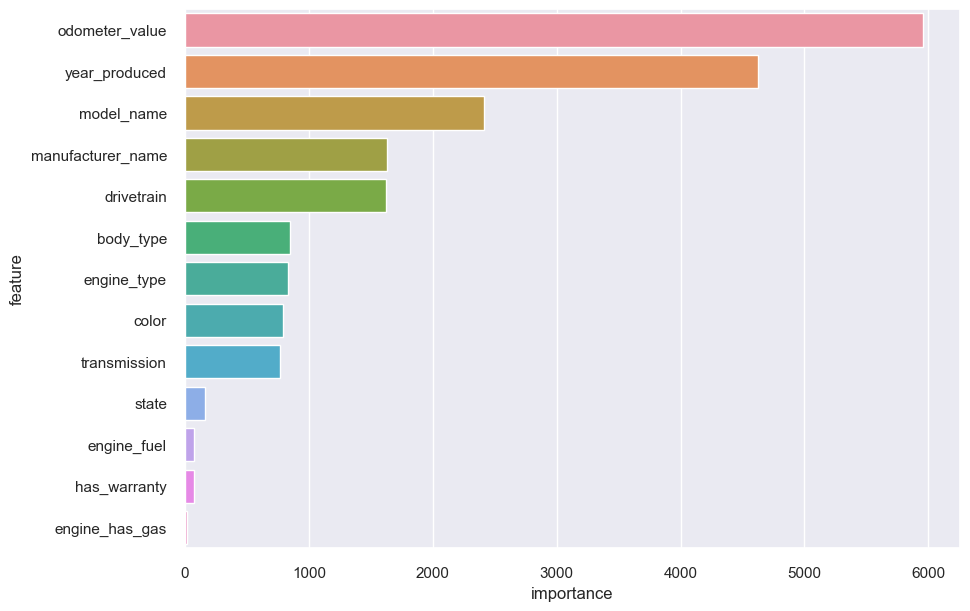

In [52]:
feat_imp = pd.DataFrame({'feature':X_train.columns, 'importance':lgbm_cv.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(y=feat_imp['feature'], x=feat_imp['importance'])

The two numerical features (“odometer_value” and “year_produced”) seem to mostly affect the model, however it is not very interpretable in what way exactly. Someone can genuinely ask the following:

· why my car’s price is predicted like that?

· what does “importance” in the x-axis mean?

· why should I care about tree splitting?

· how are features combined?

· how every feature affects a prediction?

· by how much?

· in what direction?

Too many questions and still no answers to the model’s behavior.


# 6. Shap

That’s where Machine Learning Explainability joins the party!

We will try to explain our model with the help of “shap” library in Python, which utilizes Shapley values and provides a game-theoretic approach to explain the output of (almost) any Machine Learning model. There are already multiple online resources about the intuition and calculation of Shapley values, so in this article we will mostly care about how to interpret them and understand their contribution to the model’s final predictions.

The “shap” library provides numerous great plots, depending on whether you need global or single-case explainability:

## 6a) General explainability

In [53]:
# Create object that can calculate SHAP values of the GridSearchCV model
explainer = shap.TreeExplainer(lgbm_cv)

# Calculate SHAP values based on X_train data (SHAP values are in USD, the same units as the target variable)
shap_values = explainer.shap_values(X)

In [54]:
X

manufacturer_name model_name transmission   color engine_fuel  \
0                  Ford     Fusion   mechanical    blue    gasoline   
1                 Dodge    Caravan    automatic  silver    gasoline   
2                  Ford     Galaxy   mechanical    blue      diesel   
3                 Mazda          6   mechanical   other    gasoline   
4                  Audi         80   mechanical   black    gasoline   
...                 ...        ...          ...     ...         ...   
30811             Mazda   Millenia    automatic   green    gasoline   
30812              Audi         A3    automatic    grey    gasoline   
30813             Mazda        626   mechanical   black    gasoline   
30814              Audi         A6    automatic  violet    gasoline   
30815             Honda    Odyssey    automatic   white    gasoline   

      engine_has_gas engine_type  body_type has_warranty  state drivetrain  \
0              False    gasoline  hatchback        False  owned      front   
1              False    gasoline    minivan        False  owned      front   
2              False      diesel    minivan        False  owned      front   
3              False    gasoline  universal        False  owned      front   
4              False    gasoline      sedan        False  owned      front   
...              ...         ...        ...          ...    ...        ...   
30811          False    gasoline      sedan        False  owned      front   
30812          False    gasoline  universal        False  owned      front   
30813          False    gasoline  hatchback        False  owned      front   
30814          False    gasoline  universal        False  owned        all   
30815          False    gasoline    minivan        False  owned      front   

       year_produced  odometer_value  
0               2006          245000  
1               2002          265542  
2               2009          168000  
3               2008          225522  
4               1991          370000  
...              ...             ...  
30811           1999          360493  
30812           2009          117000  
30813           1997          333000  
30814           1995          530000  
30815           2018           15000  

[30816 rows x 13 columns]

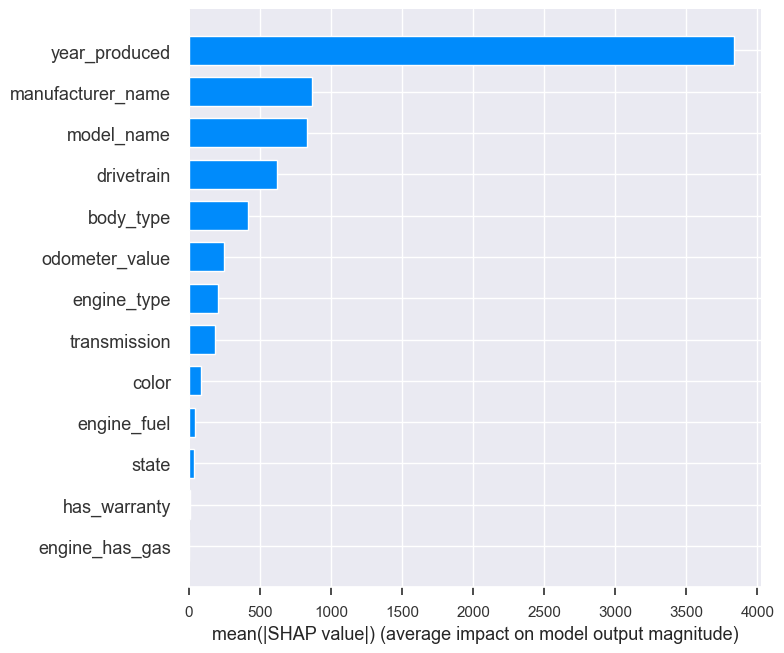

In [55]:
shap.summary_plot(shap_values, X, plot_type="bar")

# The "year_produced", i.e. the age, has by far the greatest contribution in predicting a car price 
# when combined by other features, followed by manufacturer and model. 
# On average, it can affect the price (either increasing or decreasing) by almost 4,000 USD.

# This also verifies the high correlation between year and price that was found previously.

# However, this plot is different than feature importance, because it shows the contribution of every 
# feature in USD (when making a prediction).

Refers to global explainability.

The “year_produced”, i.e. the age, has by far the greatest contribution in predicting a car price when combined by other features, followed by manufacturer and model.

Pay attention to that please, the Shapley methodology displays contribution of every feature, not importance measured by the tree’s splits. The x-axis refers to actual USD!

On average, “year_produced” can affect the price (either increasing or decreasing) by almost 4,000 USD.

This also verifies the high correlation between year and price that was found previously.

Once again, this plot is different than feature importance, because it shows the contribution of every feature in USD (when making a prediction), which is something measurable. I know I just repeated myself, but it is crucial to make this differentiation clear.

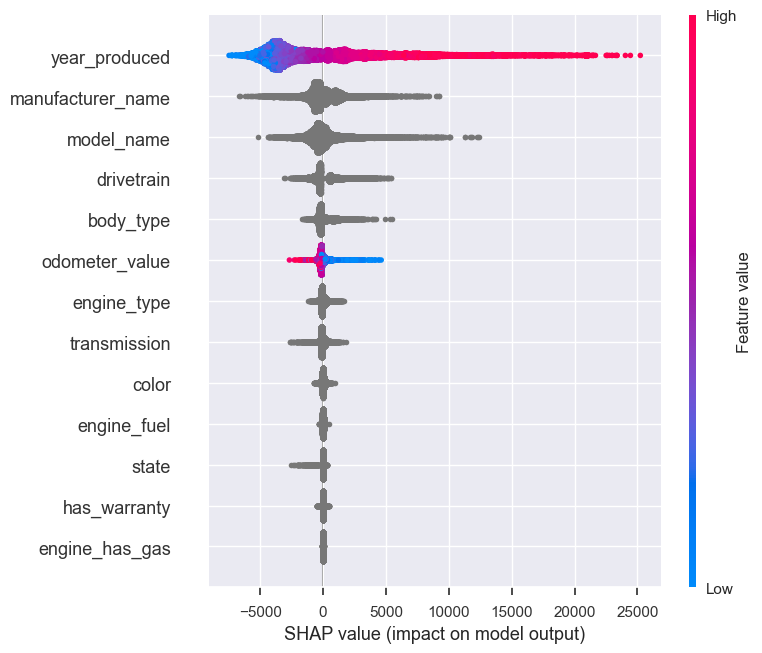

In [56]:
shap.summary_plot(shap_values, X)

# This works only for numerical features like year and odometer value:
# -> Red means high values of a feature (e.g. year=2020), while blue means small values (e.g. 1950).
# -> Distance from axis means magnitude of impact of this feature (how impactful/powerful is), 
# depending on high/small values.
# -> Side of axis is related to direction of prediction. When the feature values are on the right side, 
# the predicted value is higher. When on the left side, the predicted value is smaller.

# We see that regarding year, high (red) values (meaning recent years) have a higher impact on the 
# model output (far away from 0) and drive the price upwards (on the right of 0 axis, on the positive side).
# However, blue values (meaning years ago) don't have that much of an impact (not far from 0) and, 
# intuitively, are related to smaller prices (on the left, on the negative).

# On the other hand, high (red) odometer values (meaning more KMs) have a lot smaller impact on 
# model output (not so far away from 0) and decrease the price (on the left of 0 axis, on the negative side).

# These results are also in accordance to the correlation plots, so they are verified.

Also refers to global explainability.

This plot however works only for numerical features like year and odometer value, but how to interpret that?

Well:

Red means high values of a feature (e.g. year=2020), while blue means small values (e.g. 1950).
Distance from axis means magnitude of impact of this feature (how impactful/powerful is), depending on high/small values.
Side of axis is related to direction of prediction. When the feature values are on the right side, the predicted value is higher. When on the left side, the predicted value is smaller.
We see that regarding year, high (red) values (meaning recent years) have a higher impact on the model output (far away from 0) and drive the price upwards (on the right of 0 axis, on the positive side).

However, blue values (meaning years ago) don’t have that much of an impact (not far from 0) and, intuitively, are related to smaller prices (on the left, on the negative).

In simpler words, newer → more expensive car.

On the other hand, high (red) odometer values (meaning more KMs) have a lot smaller impact on model output (not so far away from 0) and decrease the price (on the left of 0 axis, on the negative side). Additionally, blue values (less KMs) increase the price.

Again in simpler words, fewer KMs → more expensive car.

These results are also in accordance to the correlation plots, so they are verified (and pretty intuitive!).

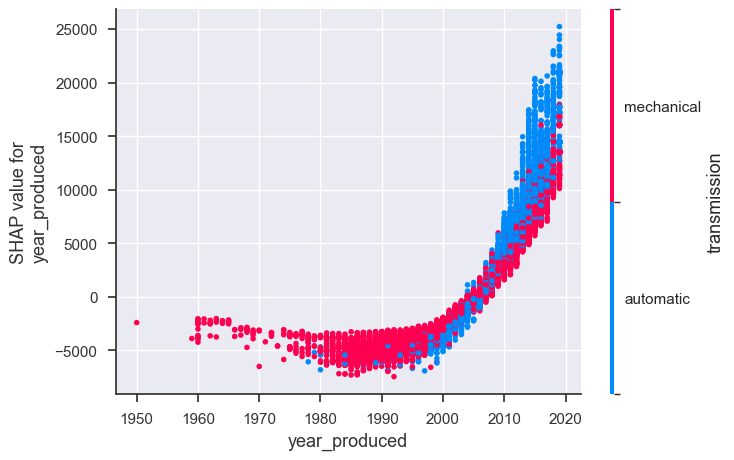

In [57]:
shap.dependence_plot('year_produced', shap_values, X)

# Here we see the interaction between a selected feature (year) and its most related one (according to 
# the SHAP algorithm, here is the transmission).

# Seems to be like the correlation plot between year and price and that makes sense. 
# But here we get another information:
# -> the impact of year is higher when the transmission is automatic, it results in a higher SHAP value. 

Global explainability as well, but now with combining features.

Here we see the interaction between a selected feature (year) and its most related one (according to the SHAP algorithm, here is the transmission).

Seems to be like the correlation plot between year and price and that makes sense. But here we get another interesting information:
the impact of year is higher when the transmission is automatic, as it results in a higher SHAP value.

In [58]:
# the average value of the price in the train set (X_train)
explainer.expected_value

6605.659596005

In [59]:
# these are the Shapley values
shap_values

array([[ -363.97038044, -1191.22004855,  -116.13026401, ...,
         -398.36002483,   326.73414288,  -111.70000374],
       [   75.45821036,  -331.81523004,   111.55628032, ...,
         -370.26879814, -2156.32132475,   -78.98581972],
       [ -266.8136288 ,  1302.74576002,  -106.12986614, ...,
         -575.29156082,  2775.38771367,    26.86210171],
       ...,
       [ -342.48485414,  -342.36030376,  -111.02050177, ...,
         -238.89130004, -3682.73940777,  -170.22488684],
       [  809.4136714 ,   932.10551879,    90.07252028, ...,
          638.99782425, -5022.55877529,  -405.06959225],
       [ 2685.11265379,  1845.24836696,  1258.84539899, ...,
         -946.37413006, 18384.18208925,  1486.3085717 ]])

## 6b) Individual explainability

Lastly, let’s try to explain a single individual prediction to find out how the model “decided”:

In [60]:
# Initialize:
shap.initjs()

# Specify case in the X_test to predict and see how every feature contributes to moving the 
# prediction from the (expected) average value to the final one:
row_to_predict = 0
data_for_prediction = X.iloc[[row_to_predict]]
prediction = lgbm.predict(data_for_prediction)[0]
print('prediction: ', prediction)

# Shap plot:
shap.force_plot(explainer.expected_value, shap_values[row_to_predict], data_for_prediction)

prediction:  4032.260147581418


In [61]:
data_for_prediction

manufacturer_name model_name transmission color engine_fuel engine_has_gas  \
0              Ford     Fusion   mechanical  blue    gasoline          False   

  engine_type  body_type has_warranty  state drivetrain  year_produced  \
0    gasoline  hatchback        False  owned      front           2006   

   odometer_value  
0          245000

In [62]:
direction = 'up' if prediction > explainer.expected_value else 'down'
direction

'down'

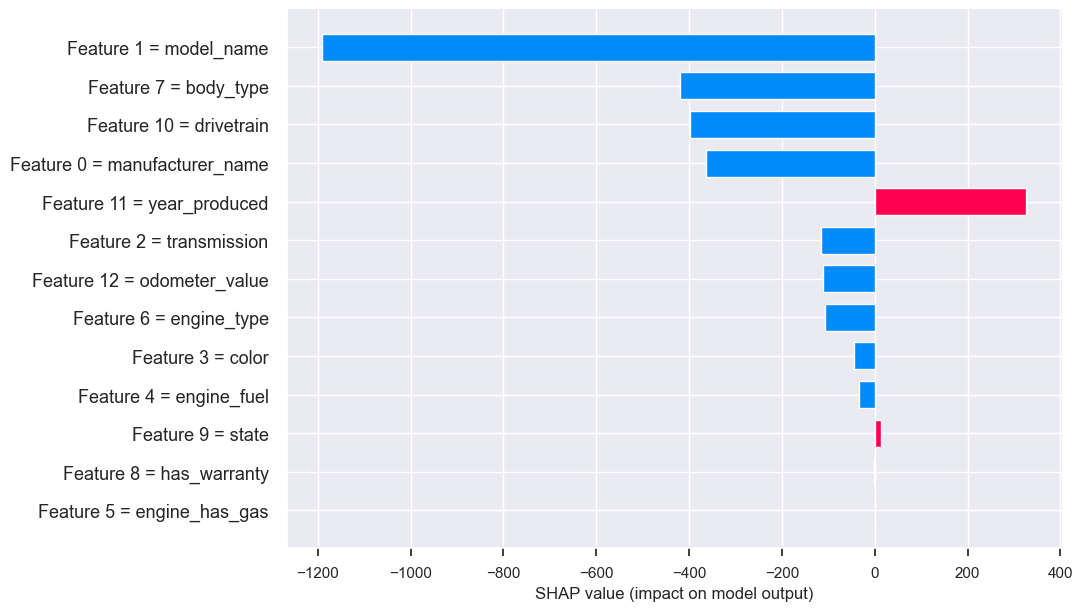

In [63]:
# Same but now in bar plot
fig = plt.figure(figsize=(10,7))
shap.bar_plot(shap_values[row_to_predict], data_for_prediction, max_display=20)

Ok, what we understand from these?

The average price is around 6,606 $. That’s the baseline value.

The predicted price (3,948 $) is driven down mainly because of these 4 reasons:

1. Model Name is Fusion and affects the price by -1293.44 $

2. Drivetrain is front and affects the price by -422.55 $

3. Body Type is hatchback and affects the price by -406.2 $

4. Manufacturer Name is Ford and affects the price by -385.37 $

In [64]:
# Create a list with the Shap values for this case
original_sv = shap_values[row_to_predict].tolist()
sv = original_sv.copy()
if direction == 'up':
    sv = [i for i in sv if i>0]
else:
    sv = [i for i in sv if i<0]
    
    
# Get the absolute values of the list and reverse it. That way we see the "top" features, 
# no matter whether prediction is greater or smaller than the average value.
rev_sv = [abs(i) for i in sv].copy()
rev_sv.sort(reverse=True)

# Keep the top 4 shap values (contributions to the prediction) and find their positions in 
# the original list
max0 = rev_sv[0] if rev_sv[0] in sv else -rev_sv[0]
max1 = rev_sv[1] if rev_sv[1] in sv else -rev_sv[1]
max2 = rev_sv[2] if rev_sv[2] in sv else -rev_sv[2]
max3 = rev_sv[3] if rev_sv[3] in sv else -rev_sv[3]
print(max0, max1, max2, max3)

max0_index = original_sv.index(max0)
max1_index = original_sv.index(max1)
max2_index = original_sv.index(max2)
max3_index = original_sv.index(max3)
print(max0_index, max1_index, max2_index, max3_index)

# Identify the feature names and their values 
feat0 = ' '.join(data_for_prediction.columns[max0_index].split('_')).title()
feat1 = ' '.join(data_for_prediction.columns[max1_index].split('_')).title()
feat2 = ' '.join(data_for_prediction.columns[max2_index].split('_')).title()
feat3 = ' '.join(data_for_prediction.columns[max3_index].split('_')).title()

val0 = data_for_prediction.iloc[0,max0_index]
val1 = data_for_prediction.iloc[0,max1_index]
val2 = data_for_prediction.iloc[0,max2_index]
val3 = data_for_prediction.iloc[0,max3_index]

-1191.2200485464139 -420.12045280500627 -398.36002482573497 -363.9703804375286
1 7 10 0


In [65]:
print('The average price is ', explainer.expected_value, '.\n')
print('The predicted price is driven ', direction, ' mainly because:', 
     '\n\t a)', feat0, 'is', val0, 'and affects the price by', round(max0,2), '$',
     '\n\t b)', feat1, 'is', val1, 'and affects the price by', round(max1,2), '$',
     '\n\t c)', feat2, 'is', val2, 'and affects the price by', round(max2,2), '$',
     '\n\t d)', feat3, 'is', val3, 'and affects the price by', round(max3,2), '$',
     )

The average price is  6605.659596005 .

The predicted price is driven  down  mainly because: 
	 a) Model Name is Fusion and affects the price by -1191.22 $ 
	 b) Body Type is hatchback and affects the price by -420.12 $ 
	 c) Drivetrain is front and affects the price by -398.36 $ 
	 d) Manufacturer Name is Ford and affects the price by -363.97 $


# 7. Save objects

In [66]:
import pickle


with open('dataset.pickle', 'wb') as handle:
    pickle.dump(df, handle)
    
    
with open('lgbm_cv.pickle', 'wb') as handle:
    pickle.dump(lgbm_cv, handle)
    
    
with open('explainer.pickle', 'wb') as handle:
    pickle.dump(explainer, handle)
    
    
with open('shap_values.pickle', 'wb') as handle:
    pickle.dump(shap_values, handle)

# Conclusion 

Well, that was a lot of coding! 😅 My main goal was to provide a way of thinking when analyzing a dataset and building/selecting the model, as well as interpreting its results and explaining its behavior. All of these steps are necessary when working on real-world Machine Learning projects. I really hope you enjoyed it!

As promised, here is the link to the Streamlit app (to test the model by yourself):
https://billykal-streamlit-cars-app-u0zzgi.streamlit.app/

and you can read more in detail about its design and creation in this article: https://medium.com/@kalyvas.v/how-i-designed-and-structured-my-first-streamlit-app-d70ddac1db62

# DoWhy for Causal Inference
## Causal Model Configuration

### Components of the Model

In our analysis, we constructed a causal model to investigate the effect of a car's production year (`year_produced`) on its odometer reading (`odometer_value`), controlling for potential confounding factors. Here are the key components of our causal model:

- **Treatment Variable**: `year_produced`
  - This is our primary variable of interest. We hypothesize that newer cars (i.e., cars produced in more recent years) will typically have lower odometer readings due to less time available to accumulate mileage.

- **Outcome Variable**: `odometer_value`
  - The outcome variable we are studying. The hypothesis is that the odometer value (which reflects the total distance that the car has traveled) is influenced by the age of the car, as represented by its production year.

- **Common Causes**: `manufacturer_name`
  - We include the `manufacturer_name` as a common cause (confounder) because different manufacturers may have different quality standards, marketing strategies, or customer bases, which might influence both the year in which a car is produced and its usage (thus affecting the odometer value). By controlling for this variable, we aim to isolate the effect of the production year from these other factors.

### Model Purpose

The purpose of this model is to estimate the Average Treatment Effect (ATE) of the `year_produced` on the `odometer_value`, specifically focusing on how much less the odometer reading would be for newer cars, accounting for the make of the car as a confounder. This analysis helps in understanding the true impact of a car's age on its usage, independent of the manufacturer's influence.


In [67]:
import dowhy
from dowhy import CausalModel

In [68]:
# Create a causal model
model = CausalModel(
    data=df,
    treatment='year_produced',
    outcome='odometer_value',
    common_causes=['manufacturer_name']  # Any confounders
)

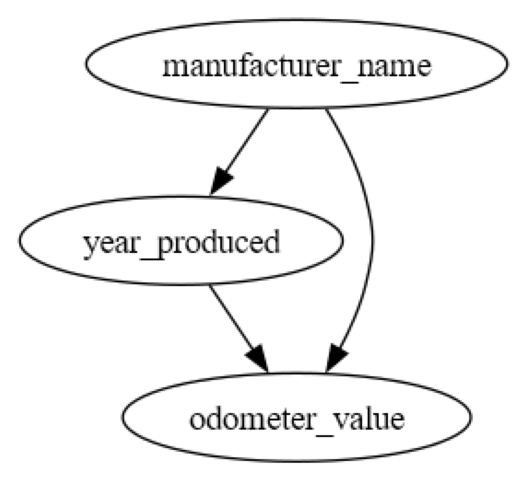

In [69]:
model.view_model()

In [74]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                             
────────────────(E[odometer_value|manufacturer_name])
d[year_produced]                                     
Estimand assumption 1, Unconfoundedness: If U→{year_produced} and U→odometer_value then P(odometer_value|year_produced,manufacturer_name,U) = P(odometer_value|year_produced,manufacturer_name)

## Realized estimand
b: odometer_value~year_produced+manufacturer_name
Target units: ate

## Estimate
Mean value: -8273.511237900704



## Causal Estimate Analysis

### Identified Estimand

**Estimand Type:** `EstimandType.NONPARAMETRIC_ATE`

- **Definition**: The Average Treatment Effect (ATE) measures the average effect of the treatment across all units in the population. "Nonparametric" indicates that no specific parametric form of the outcome distribution is assumed.

#### Estimand: 1

- **Name**: `backdoor`
- **Expression**:
  $$
  \frac{d}{d [\text{year\_produced}]} \mathbb{E}[\text{odometer\_value} | \text{manufacturer\_name}]
  $$
  This mathematical expression computes the derivative of the expected odometer value with respect to the car's production year, holding the manufacturer's name constant.

- **Unconfoundedness Assumption**:
  If U→{year_produced} and U→odometer_value, then \( P(\text{odometer\_value}|\text{year\_produced}, \text{manufacturer\_name}, U) = P(\text{odometer\_value}|\text{year\_produced}, \text{manufacturer\_name}) \)
  - This states that all confounders are either controlled for, or there are no unobserved confounders influencing both the treatment and the outcome, allowing for an unbiased estimate of the causal effect.

### Realized Estimand

- **Model**: `odometer_value ~ year_produced + manufacturer_name`
  - This linear regression model predicts `odometer_value` using `year_produced` and `manufacturer_name`, where `year_produced` is the treatment and `manufacturer_name` is a confounder.

- **Target Units**: `ate` (Average Treatment Effect)
  - The effect measured is the average change in the `odometer_value` for a one-unit increase in `year_produced` across the entire population.

### Estimate

- **Mean Value**: `-8273.511237900704`
  - The model estimates that, on average, each additional year in the `year_produced` is associated with a decrease of approximately 8273.51 in the `odometer_value`. This suggests that newer cars (higher `year_produced`) typically have lower odometer readings, as expected.


In [75]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:-8273.511237900704
New effect:22.029395482114705
p value:0.38713151550183955



### Refutation Test: Use a Placebo Treatment

#### Overview

This refutation test involves replacing the actual treatment variable (`year_produced`) with a placebo variable (a variable that should have no causal effect on the outcome) to test the robustness of the estimated causal effect. This is crucial for validating the causal inference by showing whether similar effects are observed with non-causal or random treatments, which should ideally not happen if the original causal estimate is robust.

#### Results

- **Original Estimated Effect**: `-8273.511237900704`
  - This value represents the estimated decrease in `odometer_value` for each additional year in `year_produced`, suggesting newer cars typically have lower odometer readings.

- **Estimated Effect with Placebo Treatment**: `5.7997943245529315`
  - With the placebo treatment, the effect size is significantly reduced and close to zero, indicating that when the treatment is not causally related to the outcome, the effect disappears or becomes negligible.

- **p-value**: `0.47109559412353463`
  - The p-value obtained in the placebo test is significantly above the conventional threshold of 0.05, suggesting that the observed effect with the placebo treatment is statistically indistinguishable from zero. This supports the hypothesis that the original treatment (year_produced) has a true causal effect on the odometer reading.

#### Conclusion

The placebo treatment refutation test supports the validity of the original causal analysis. The significant difference between the effects observed with the actual and placebo treatments underscores the importance of the `year_produced` variable in driving the changes in `odometer_value`.
